<a href="https://colab.research.google.com/github/maryembenghouma/Data-science-Projects/blob/main/Deep_LearningVersionModifieMIMIr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Understanding**

**The project aims to improve object detection in optical remote sensing images using an adaptive Mask RCNN model. This technology is critical for applications in both civilian and military domains, where fast and accurate identification of objects in satellite imagery is required.**

**Surveillance and Security:**


*   Detection of unauthorized vehicles or aircraft in restricted areas.
*   Monitoring of military bases or borders to detect potential threats.
*   Identifying unusual activities in high-security zones.

**Urban Planning and Infrastructure:**

*   Detecting changes in urban environments, such as new construction, road networks, and public infrastructure.
*   Monitoring the growth of cities and identifying illegal constructions.

**Environmental Monitoring:**

*   Detecting changes in natural landscapes, such as deforestation or water level changes.
*   Monitoring environmental disasters like oil spills or forest fires.

**Surveillance and Security:**

*   Detection of unauthorized vehicles or aircraft in restricted areas.
*   Monitoring of military bases or borders to detect potential threats.
*   Identifying unusual activities in high-security zones.










# Load Data ( Positive images / Negative images /Annotation )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

def load_images_from_folder(folder):
    images = []
    filenames = []
    original_sizes = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            original_size = img.shape[:2]  # Capture original size
            original_sizes.append(original_size)
            images.append(img)
            filenames.append(filename)
    return images, filenames, original_sizes

def load_annotations_from_folder(folder, filenames, target_size=(224, 224)):
    annotations = []
    for idx, filename in enumerate(filenames):
        annot_filename = os.path.splitext(filename)[0] + '.txt'
        annot_file = os.path.join(folder, annot_filename)
        boxes = []
        with open(annot_file, 'r') as file:
            for line in file.readlines():
                parts = line.replace('(', '').replace(')', '').replace(',', ' ').split()
                i = 0
                while i < len(parts) - 4:
                    try:
                        x_min = int(float(parts[i].strip()))
                        y_min = int(float(parts[i+1].strip()))
                        x_max = int(float(parts[i+2].strip()))
                        y_max = int(float(parts[i+3].strip()))
                        class_id = int(parts[i+4].strip())
                        boxes.append([x_min, y_min, x_max, y_max, class_id])
                        i += 10
                    except ValueError as e:
                        print(f"Error parsing line '{line}': {e}")
                        i += 10
        annotations.append(boxes)
    return annotations


# **Data Understanding**
*Overview:*


The NWPU VHR-10 dataset comprises images extracted from Google Earth, one of the most widely used platforms for high-resolution satellite imagery. The dataset was manually annotated by experts to ensure accuracy.

**Content:**

Classes: The dataset contains 10 classes of objects, which include both man-made and natural objects commonly found in remote sensing imagery. The classes are:


Airplane


Ship


Storage Tank


Baseball Diamond


Tennis Court


Basketball Court


Ground Track Field


Harbor


Bridge


Vehicle


Total Images: The NWPU VHR-10 dataset contains a total of 800 images.


Annotations: The dataset includes annotated bounding boxes for each of the 10 object classes. These annotations identify the specific regions within each image where the respective objects are located.

In [ ]:
## Suppress warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')
# Core libraries for data processing and mathematical operations
import matplotlib.pyplot as plt
import numpy as np
# Deep learning libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import json
from PIL import Image, ImageDraw
import skimage.draw

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config



from mrcnn import utils


In [ ]:
import os

# Walk through NWPU directory and list number of files
for dirpath, dirnames, filenames in os.walk(r".\NWPU VHR-10 dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 1 images in '.\NWPU VHR-10 dataset'.
There are 0 directories and 650 images in '.\NWPU VHR-10 dataset\ground truth'.
There are 0 directories and 150 images in '.\NWPU VHR-10 dataset\negative image set'.
There are 0 directories and 650 images in '.\NWPU VHR-10 dataset\positive image set'.


# COCO JSON FORMAT



In [ ]:
positive_image_folder = r".\NWPU VHR-10 dataset\positive image set"
ground_truth_folder = r".\NWPU VHR-10 dataset\ground truth"

# Define output annotation file
output_annotation_file = "annotations.json"
# Define the mapping of class names to IDs
class_mapping = {
    "airplane": 1,
    "ship": 2,
    "storage tank": 3,
    "baseball diamond": 4,
    "tennis court": 5,
    "basketball court": 6,
    "ground track field": 7,
    "harbor": 8,
    "bridge": 9,
    "vehicle": 10
}
image_id = 0



In [ ]:
coco_data = {"images": [], "annotations": [], "categories": []}

for filename in os.listdir(ground_truth_folder):
    if filename.endswith('.txt'):
        txt_file_path = os.path.join(ground_truth_folder, filename)
        image_file_path = os.path.join(positive_image_folder, filename.replace('.txt', '.jpg'))

        with open(txt_file_path, 'r') as f:
            lines = f.readlines()

            # Open the image to get its height and width
            with Image.open(image_file_path) as img:
                image_width, image_height = img.size

            # Add image entry to coco_data
            image_entry = {
                "id": image_id,
                "file_name": image_file_path,
                "height": image_height,
                "width": image_width
            }
            coco_data['images'].append(image_entry)
            image_id += 1

            # Iterate over each line in the text file
            for line in lines:
                line = line.strip()  # Remove leading/trailing white spaces
                # Extract the bounding box coordinates and object class
                values = line.split('),')
                # Ensure the line contains at least 2 values (x1,y1),(x2,y2),a
                if len(values) >= 3:
                    # Extract the values for bounding box coordinates and object class
                    x1, y1 = map(int, values[0].replace('(', '').split(','))
                    x2, y2 = map(int, values[1].replace('(', '').split(','))

                    obj_class = int(values[2])

                    # Create a dictionary for the annotation
                    annotation = {
                        'image_id': image_id - 1,  # Image ID corresponds to index in the images list
                        'category_id': obj_class,  # Assuming object class is the category ID
                        'bbox': [x1,y1,x2,y2],  # COCO bbox format: [x, y, width, height]
                        'area': (x2 - x1) * (y2 - y1),  # Assuming area is bbox width * height
                        'iscrowd': 0  # Set to 0 for non-crowd annotations
                    }

                    # Append the annotation to the coco_data
                    coco_data['annotations'].append(annotation)

# Define categories
categories = [{"id": class_id, "name": class_name} for class_name, class_id in class_mapping.items()]

# Add categories to coco_data
coco_data['categories'] = categories

# Write the coco_data to the output annotation file
with open(output_annotation_file, 'w') as f:
    json.dump(coco_data, f, indent=4)

In [ ]:
class CocoLikeDataset(utils.Dataset):
    def load_data(self,annotation_json,images_dir):
        json_file=open(annotation_json)
        coco_json=json.load(json_file)
        json_file.close()
        source_name="coco_like"
        for category in coco_json['categories']:
            class_id=category['id']
            class_name=category['name']
            if class_id<1:
                print('Error: Class id for "{}" cannot be less than one '.format(class_name))
                return
            self.add_class(source_name,class_id,class_name)
        annotations={}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id]=[]
            annotations[image_id].append(annotation)


        seen_images={}
        for image in coco_json['images']:
            image_id=image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id : {}".format(image))
            else:
                seen_images[image_id]=image
                try:
                    image_file_name=image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key : {}".format(image_id,key))
                image_path=os.path.abspath(os.path.join(images_dir,image_file_name))
                image_annotations=annotations[image_id]
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
    def load_mask(self,image_id):
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            print(annotation['bbox'])
            array=annotation['bbox']
            mask_draw.rectangle(array, fill=1)
            bool_array = np.array(mask) > 0
            instance_masks.append(bool_array)
            class_ids=np.append(class_ids,class_id)

            mask = np.dstack(instance_masks)
            class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids

## Positive images


## Resizing of the images

In [ ]:
## Suppress warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')
# Core libraries for data processing and mathematical operations
import matplotlib.pyplot as plt
import numpy as np
# Deep learning libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import json
from PIL import Image, ImageDraw
import skimage.draw

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config



from mrcnn import utils


In [ ]:
import os

# Walk through NWPU directory and list number of files
for dirpath, dirnames, filenames in os.walk(r".\NWPU VHR-10 dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 1 images in '.\NWPU VHR-10 dataset'.
There are 0 directories and 650 images in '.\NWPU VHR-10 dataset\ground truth'.
There are 0 directories and 150 images in '.\NWPU VHR-10 dataset\negative image set'.
There are 0 directories and 650 images in '.\NWPU VHR-10 dataset\positive image set'.


In [ ]:
positive_image_folder = r".\NWPU VHR-10 dataset\positive image set"
ground_truth_folder = r".\NWPU VHR-10 dataset\ground truth"

# Define output annotation file
output_annotation_file = "annotations.json"
# Define the mapping of class names to IDs
class_mapping = {
    "airplane": 1,
    "ship": 2,
    "storage tank": 3,
    "baseball diamond": 4,
    "tennis court": 5,
    "basketball court": 6,
    "ground track field": 7,
    "harbor": 8,
    "bridge": 9,
    "vehicle": 10
}
image_id = 0



In [ ]:
coco_data = {"images": [], "annotations": [], "categories": []}

for filename in os.listdir(ground_truth_folder):
    if filename.endswith('.txt'):
        txt_file_path = os.path.join(ground_truth_folder, filename)
        image_file_path = os.path.join(positive_image_folder, filename.replace('.txt', '.jpg'))

        with open(txt_file_path, 'r') as f:
            lines = f.readlines()

            # Open the image to get its height and width
            with Image.open(image_file_path) as img:
                image_width, image_height = img.size

            # Add image entry to coco_data
            image_entry = {
                "id": image_id,
                "file_name": image_file_path,
                "height": image_height,
                "width": image_width
            }
            coco_data['images'].append(image_entry)
            image_id += 1

            # Iterate over each line in the text file
            for line in lines:
                line = line.strip()  # Remove leading/trailing white spaces
                # Extract the bounding box coordinates and object class
                values = line.split('),')
                # Ensure the line contains at least 2 values (x1,y1),(x2,y2),a
                if len(values) >= 3:
                    # Extract the values for bounding box coordinates and object class
                    x1, y1 = map(int, values[0].replace('(', '').split(','))
                    x2, y2 = map(int, values[1].replace('(', '').split(','))

                    obj_class = int(values[2])

                    # Create a dictionary for the annotation
                    annotation = {
                        'image_id': image_id - 1,  # Image ID corresponds to index in the images list
                        'category_id': obj_class,  # Assuming object class is the category ID
                        'bbox': [x1,y1,x2,y2],  # COCO bbox format: [x, y, width, height]
                        'area': (x2 - x1) * (y2 - y1),  # Assuming area is bbox width * height
                        'iscrowd': 0  # Set to 0 for non-crowd annotations
                    }

                    # Append the annotation to the coco_data
                    coco_data['annotations'].append(annotation)

# Define categories
categories = [{"id": class_id, "name": class_name} for class_name, class_id in class_mapping.items()]

# Add categories to coco_data
coco_data['categories'] = categories

# Write the coco_data to the output annotation file
with open(output_annotation_file, 'w') as f:
    json.dump(coco_data, f, indent=4)

In [ ]:
class CocoLikeDataset(utils.Dataset):
    def load_data(self,annotation_json,images_dir):
        json_file=open(annotation_json)
        coco_json=json.load(json_file)
        json_file.close()
        source_name="coco_like"
        for category in coco_json['categories']:
            class_id=category['id']
            class_name=category['name']
            if class_id<1:
                print('Error: Class id for "{}" cannot be less than one '.format(class_name))
                return
            self.add_class(source_name,class_id,class_name)
        annotations={}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id]=[]
            annotations[image_id].append(annotation)


        seen_images={}
        for image in coco_json['images']:
            image_id=image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id : {}".format(image))
            else:
                seen_images[image_id]=image
                try:
                    image_file_name=image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key : {}".format(image_id,key))
                image_path=os.path.abspath(os.path.join(images_dir,image_file_name))
                image_annotations=annotations[image_id]
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
    def load_mask(self,image_id):
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            print(annotation['bbox'])
            array=annotation['bbox']
            mask_draw.rectangle(array, fill=1)
            bool_array = np.array(mask) > 0
            instance_masks.append(bool_array)
            class_ids=np.append(class_ids,class_id)

            mask = np.dstack(instance_masks)
            class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids

*LOADING A COCOJSON DATA*

[575, 114, 635, 162]
[72, 305, 133, 369]
[210, 317, 273, 384]
[306, 374, 344, 420]
[447, 531, 535, 632]
[546, 605, 625, 707]
[632, 680, 720, 790]


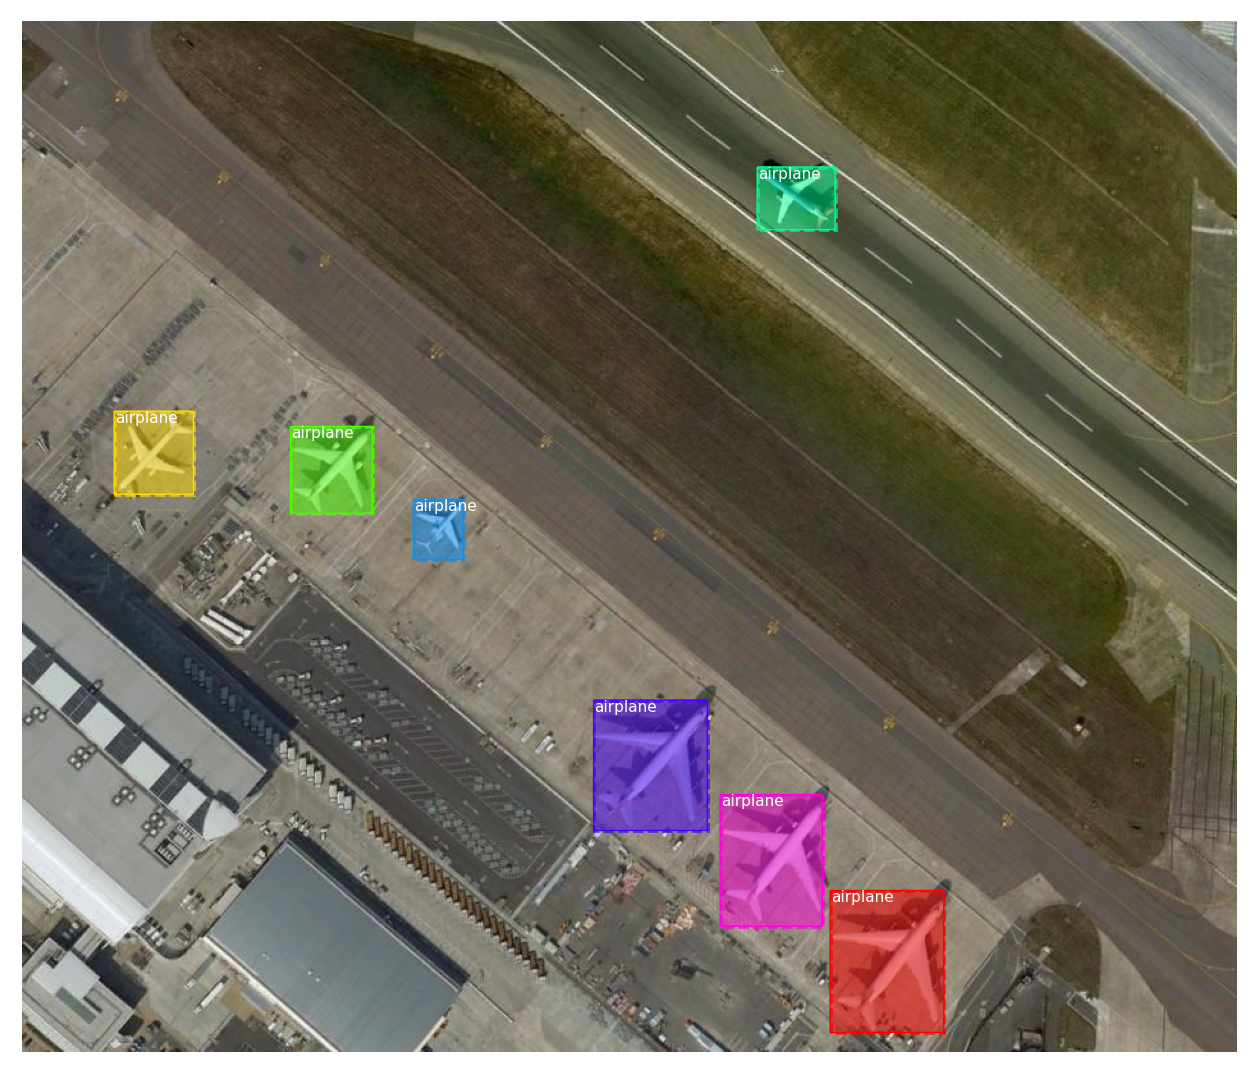

In [ ]:
image_id = 1
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [ ]:
import cv2

def resize_images(images, target_size=(1024, 1024)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
    return resized_images

def resize_annotations(annotations, original_sizes, target_size=(1024, 1024)):
    resized_annotations = []
    for idx, annot in enumerate(annotations):
        original_height, original_width = original_sizes[idx]
        scale_x = target_size[0] / original_width
        scale_y = target_size[1] / original_height
        resized_boxes = []
        for box in annot:
            x_min = int(box[0] * scale_x)
            y_min = int(box[1] * scale_y)
            x_max = int(box[2] * scale_x)
            y_max = int(box[3] * scale_y)
            class_id = box[4]
            resized_boxes.append([x_min, y_min, x_max, y_max, class_id])
        resized_annotations.append(resized_boxes)
    return resized_annotations

# Resizing positive images
target_size = (1024, 1024)  # Define your target size here
resized_positive_images = resize_images(positive_images, target_size)
resized_negative_images = resize_images(negative_images, target_size)

# Resizing positive annotations
resized_positive_annotations = resize_annotations(positive_annotations, positive_original_sizes, target_size)

## Data augmentation



**Multiple Individual Augmentations:**

**Pros:** This method allows the model to learn from a wider variety of simple changes, potentially improving its ability to generalize from each type of transformation individually. It increases the effective size of the training dataset more significantly, which can be beneficial for training deep learning models.

**Cons:** The main drawback is increased computational and storage requirements since you're generating multiple images for each original image in the dataset. It might also introduce redundancy if the transformations are too mild or too correlated.
Best Practices

**Balanced Approach:** Often, a mix of both strategies is employed. For example, you might apply mild transformations (like slight rotations and flips) individually to generate multiple images and then perform a few combined transformations (like moderate zoom followed by a slight rotation) to create more diverse scenarios.
Experimentation and Validation: It's important to experiment with different strategies and validate their impact on model performance. Monitoring how each type of augmentation affects overfitting, underfitting, and validation accuracy can guide you to optimize the augmentation pipeline.
Resource Management: Consider your computational resources and training time. More images mean longer training times and more disk space. If resources are limited, focusing on the most impactful transformations might be necessary.

## Data Augmentation For Negative Images

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def adjust_brightness_negative(image, brightness_factor):
    """ Adjust the brightness of an image. """
    return cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)

def flip_horizontal_negative(image):
    """Flip image horizontally."""
    return cv2.flip(image, 1)  # 1 means horizontal flip

def flip_vertical_negative(image):
    """Flip image vertically."""
    return cv2.flip(image, 0)  # 0 means vertical flip

def generate_augmented_images_negative(original_img, zoom_factors, angles, brightness_factors):
    augmented_images = []

    # 1. Zoom + Rotation:
    zoom_factor = np.random.choice(zoom_factors)
    new_width = int(original_img.shape[1] * zoom_factor)
    new_height = int(original_img.shape[0] * zoom_factor)
    zoomed_rotation_img = cv2.resize(original_img, (new_width, new_height))
    start_x = (new_width - original_img.shape[1]) // 2
    start_y = (new_height - original_img.shape[0]) // 2
    zoomed_rotation_img = zoomed_rotation_img[start_y:start_y + original_img.shape[0], start_x:start_x + original_img.shape[1]]
    angle = np.random.choice(angles)
    zoomed_rotation_img = cv2.warpAffine(zoomed_rotation_img, cv2.getRotationMatrix2D((zoomed_rotation_img.shape[1] / 2, zoomed_rotation_img.shape[0] / 2), angle, 1), (zoomed_rotation_img.shape[1], zoomed_rotation_img.shape[0]))
    augmented_images.append(zoomed_rotation_img)

    # 2. Brightness Adjustment + Vertical Flip:
    v_flip_img = flip_vertical_negative(original_img)
    brightness_factor = np.random.choice(brightness_factors)
    v_flip_img = adjust_brightness_negative(v_flip_img, brightness_factor)
    augmented_images.append(v_flip_img)

    # 3. Zoom + Brightness Adjustment:
    zoom_factor = np.random.choice(zoom_factors)
    new_width = int(original_img.shape[1] * zoom_factor)
    new_height = int(original_img.shape[0] * zoom_factor)
    zoomed_brightness_img = cv2.resize(original_img, (new_width, new_height))
    start_x = (new_width - original_img.shape[1]) // 2
    start_y = (new_height - original_img.shape[0]) // 2
    zoomed_brightness_img = zoomed_brightness_img[start_y:start_y + original_img.shape[0], start_x:start_x + original_img.shape[1]]
    brightness_factor = np.random.choice(brightness_factors)
    zoomed_brightness_img = adjust_brightness_negative(zoomed_brightness_img, brightness_factor)
    augmented_images.append(zoomed_brightness_img)

    # Rotation augmentation
    angle = np.random.choice(angles)
    rotated_img = cv2.warpAffine(original_img, cv2.getRotationMatrix2D((original_img.shape[1] / 2, original_img.shape[0] / 2), angle, 1), (original_img.shape[1], original_img.shape[0]))
    augmented_images.append(rotated_img)

    # Horizontal Flip
    h_flip_img = flip_horizontal_negative(original_img)
    augmented_images.append(h_flip_img)

    return augmented_images

def display_augmentations_negative(original_img):
    zoom_factors = [1.2, 1.4, 1.6, 1.8, 2.0]  # Factors for zooming
    angles = [10, 20, 30, -10, -20, -30]       # Degrees for rotation
    brightness_factors = [0.5, 0.7, 1.3, 1.5]  # Factors for brightness adjustment

    aug_imgs = generate_augmented_images_negative(original_img, zoom_factors, angles, brightness_factors)
    fig, axes = plt.subplots(1, len(aug_imgs), figsize=(20, 5))  # Adding original image as well
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[0].axis('off')

    for ax, img in zip(axes[1:], aug_imgs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage (assuming you have resized_negative_images defined)
for img in resized_negative_images[:1]:  # Displaying first 5 images for example
    display_augmentations_negative(img)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Ensure OpenCV is imported for image processing

# Initialize lists to hold all negative images
all_negative_images = []

# Iterate over each negative image
for img in resized_negative_images:

    zoom_factors = [1.2, 1.4, 1.6, 1.8, 2.0]  # Factors for zooming
    angles = [10, 20, 30, -10, -20, -30]       # Degrees for rotation
    brightness_factors = [0.5, 0.7, 1.3, 1.5]  # Factors for brightness adjustment
    # Generate augmented images
    augmented_images = generate_augmented_images_negative(img, zoom_factors, angles, brightness_factors)

    # Append the original image first
    all_negative_images.append(img)

    # Extend list with the augmented images
    all_negative_images.extend(augmented_images)

# Displaying the original and augmented images
fig, axes = plt.subplots(2, 4, figsize=(20, 8))  # Adjust the subplot grid as necessary
for ax, img in zip(axes.flatten(), all_negative_images[:8]):  # Ensure we don't exceed the grid size
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the number of images in all_images
number_of_negative_images = len(all_negative_images)

# Print the result
print("Total number of images Negative images after data augmentation:", number_of_negative_images)

## Split Data

# **Fine Tuning ResNet 50**

In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 502456, done.
remote: Counting objects: 100% (16066/16066), done.
remote: Compressing objects: 100% (809/809), done.
remote: Total 502456 (delta 15275), reused 15996 (delta 15230), pack-reused 486390
Receiving objects: 100% (502456/502456), 973.34 MiB | 23.03 MiB/s, done.
Resolving deltas: 100% (468510/468510), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import numpy as np
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

from torchvision.transforms import functional as F

In [ ]:
class ImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height,ID,CLASS,BOX, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.bbox_dir= bbox_dir
        self.height = height
        self.width = width
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = ID
        self.box=BOX
        self.Class=CLASS


        # classes: 0 index is reserved for background
        self.classes= [_,1,2,3,4,5,6,7,8,9,10]
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name +'.jpg')

        # reading the images and converting them to correct size and color
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        #diving by 255
        img_res /= 255.0

        # annotation file
        annot_filename = img_name + '.txt'
        annot_file_path = os.path.join(self.bbox_dir, annot_filename)
        bb=[]
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        # convert boxes into a torch.Tensor
        bbox=self.box[idx]
        for box in bbox:
            xmin_corr = (box[0]/wt)*self.width
            xmax_corr = (box[2]/wt)*self.width
            ymin_corr = (box[1]/ht)*self.height
            ymax_corr = (box[3]/ht)*self.height
            bb.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        boxes = torch.as_tensor(bb, dtype=torch.float32)
#         boxes = torch.as_tensor([xmin_corr, ymin_corr, xmax_corr, ymax_corr], dtype=torch.float32)

        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        #area = (boxes[3] - boxes[1]) * (boxes[2] - boxes[0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(self.Class[idx], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id=idx
#         image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
#             print(img_res.shape)
#             print(target['boxes'])
#             print(labels.view(-1))
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels.view(-1))

            img_res = sample['image']
#             img_res = img_res.permute(1, 2, 0)
            target['boxes'] = torch.Tensor(sample['bboxes'])
            target["labels"] = labels.view(-1)
#             target['boxes'] = sample['bboxes']
#             print("---------------------------")
#             print(img_res.shape)
#             print(target['boxes'])
#             print(labels.view(-1))
#             print("----------------------------")
#         print(target)
        return torch.tensor(img_res), target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# defining the files directory and testing directory
files_dir = '/content/drive/MyDrive/dataset/positive image set'
neg_dir = '/content/drive/MyDrive/dataset/negative image set'
bbox_dir = '/content/drive/MyDrive/dataset/ground truth'
#random_dir ='/kaggle/input/random-test'


In [ ]:
def getressources():
        # Chemin vers votre répertoire contenant les fichiers
        repertoire = "/content/drive/MyDrive/dataset/ground truth"

        # Initialisation des listes
        noms_fichiers = []
        box_data = []
        class_data = []

        # Parcours des fichiers dans le répertoire
        for nom_fichier in os.listdir(repertoire):
            chemin_fichier = os.path.join(repertoire, nom_fichier)
            # Vérification que le chemin correspond à un fichier et non à un répertoire
            if os.path.isfile(chemin_fichier):
                nom_sans_extension = os.path.splitext(nom_fichier)[0]
                with open(chemin_fichier, 'r') as f:
                    contenu_fichier = f.read()
                    noms_fichiers.append(nom_sans_extension)
                    lignes = contenu_fichier.strip().split('\n')
                    boxes = []
                    classes = []
                    for ligne in lignes:
                        elements = ligne.split(',')
                        box = [int(elem.strip("() ")) for elem in elements[:4]]
                        classe = int(elements[4])
                        boxes.append(box)
                        classes.append(classe)
                    box_data.append(boxes)
                    class_data.append(classes)

        # Création du DataFrame
#         data = {'ID': noms_fichiers, 'BOX': box_data, 'Class': class_data}
#         df = pd.DataFrame(data)
#         print(df.head())
#         C=[]
#         B=[]
#         I=[]
#         for index, rows in df.iterrows() :
#             Class=rows['Class']
#             Box=rows["BOX"]
#             ID=rows["ID"]
#             for i in range(len(Class)):
#                 B.append(Box[i])
#                 C.append(Class[i])
#                 I.append(ID)
#         data = {'ID': I, 'BOX': B, 'Class': C}
#         df = pd.DataFrame(data)
#         return(I,B,C)
        return(noms_fichiers,box_data,class_data)

In [ ]:
ID,BOX,CLASS=getressources()

In [ ]:
print(len(ID))

650


In [ ]:
# Transformation for image resizing and normalization
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# use our dataset and defined transformations
dataset = ImagesDataset(files_dir, 480, 480,ID,CLASS,BOX,transforms= get_transform(train=True))
dataset_test = ImagesDataset(files_dir, 480, 480,ID,CLASS,BOX,transforms= get_transform(train=False))



# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
# Model setup
def get_object_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 11

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 85.6MB/s]


In [ ]:
device

device(type='cuda')

In [ ]:
# training for 8 epochs # sgd
num_epochs = 15

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/104]  eta: 0:21:39  lr: 0.000053  loss: 2.5010 (2.5010)  loss_classifier: 2.0748 (2.0748)  loss_box_reg: 0.2147 (0.2147)  loss_objectness: 0.1990 (0.1990)  loss_rpn_box_reg: 0.0125 (0.0125)  time: 12.4959  data: 6.5333  max mem: 3715
Epoch: [0]  [ 10/104]  eta: 0:03:02  lr: 0.000538  loss: 2.1539 (1.9279)  loss_classifier: 1.6329 (1.4351)  loss_box_reg: 0.2379 (0.2459)  loss_objectness: 0.1990 (0.2296)  loss_rpn_box_reg: 0.0125 (0.0173)  time: 1.9377  data: 0.6165  max mem: 3875
Epoch: [0]  [ 20/104]  eta: 0:02:00  lr: 0.001023  loss: 1.2824 (1.5006)  loss_classifier: 0.7298 (1.0260)  loss_box_reg: 0.2868 (0.2820)  loss_objectness: 0.1409 (0.1747)  loss_rpn_box_reg: 0.0126 (0.0178)  time: 0.8862  data: 0.0234  max mem: 3875
Epoch: [0]  [ 30/104]  eta: 0:01:33  lr: 0.001508  loss: 1.1755 (1.3630)  loss_classifier: 0.6021 (0.8697)  loss_box_reg: 0.3267 (0.3174)  loss_objectness: 0.0952 (0.1566)  loss_rpn_box_reg: 0.0171 (0.0194)  time: 0.8888  data: 0.0215  max mem: 3875

In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 11

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# training for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/104]  eta: 0:11:35  lr: 0.000053  loss: 2.7235 (2.7235)  loss_classifier: 2.3228 (2.3228)  loss_box_reg: 0.2357 (0.2357)  loss_objectness: 0.1499 (0.1499)  loss_rpn_box_reg: 0.0151 (0.0151)  time: 6.6916  data: 4.5670  max mem: 4198
Epoch: [0]  [ 10/104]  eta: 0:02:26  lr: 0.000538  loss: 2.5347 (2.2935)  loss_classifier: 1.8309 (1.6350)  loss_box_reg: 0.3244 (0.3192)  loss_objectness: 0.2873 (0.3125)  loss_rpn_box_reg: 0.0241 (0.0267)  time: 1.5552  data: 0.4836  max mem: 4355
Epoch: [0]  [ 20/104]  eta: 0:01:51  lr: 0.001023  loss: 1.2679 (1.6503)  loss_classifier: 0.7718 (1.1099)  loss_box_reg: 0.2971 (0.3030)  loss_objectness: 0.1352 (0.2163)  loss_rpn_box_reg: 0.0162 (0.0212)  time: 1.0557  data: 0.0636  max mem: 4355
Epoch: [0]  [ 30/104]  eta: 0:01:30  lr: 0.001508  loss: 0.9645 (1.4740)  loss_classifier: 0.4899 (0.9395)  loss_box_reg: 0.3449 (0.3378)  loss_objectness: 0.0906 (0.1763)  loss_rpn_box_reg: 0.0142 (0.0204)  time: 1.0487  data: 0.0617  max mem: 4355


In [ ]:
#save adamn
import pickle
Filename = "FRCNNsgd.pkl"
# Define the file path where you want to save the model
filename = "/content/drive/MyDrive/dataset/FRCNNsgd.pkl"

# Save the model to the specified file path
torch.save(model.state_dict(), filename)
# Save the Modle to file in the current working directory
with open(Filename, 'wb') as file:
    pickle.dump(model, file)
# Load the Model back from file
with open(Filename, 'rb') as file:
    model = pickle.load(file)
model


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# to train on GPU if selected
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# number of classes
num_classes = 11

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [ ]:
# training for 8 epochs # adam
num_epochs = 15

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/104]  eta: 0:03:27  lr: 0.000011  loss: 3.4412 (3.4412)  loss_classifier: 2.6871 (2.6871)  loss_box_reg: 0.2420 (0.2420)  loss_objectness: 0.4842 (0.4842)  loss_rpn_box_reg: 0.0278 (0.0278)  time: 1.9959  data: 0.8924  max mem: 6508
Epoch: [0]  [ 10/104]  eta: 0:01:51  lr: 0.000108  loss: 1.9666 (2.0528)  loss_classifier: 1.1984 (1.5021)  loss_box_reg: 0.3116 (0.3519)  loss_objectness: 0.1556 (0.1792)  loss_rpn_box_reg: 0.0162 (0.0196)  time: 1.1900  data: 0.0974  max mem: 6508
Epoch: [0]  [ 20/104]  eta: 0:01:37  lr: 0.000205  loss: 1.0744 (1.5374)  loss_classifier: 0.5573 (1.0176)  loss_box_reg: 0.3418 (0.3596)  loss_objectness: 0.1066 (0.1406)  loss_rpn_box_reg: 0.0162 (0.0196)  time: 1.1201  data: 0.0198  max mem: 6508
Epoch: [0]  [ 30/104]  eta: 0:01:23  lr: 0.000302  loss: 0.8417 (1.3277)  loss_classifier: 0.4224 (0.8269)  loss_box_reg: 0.3510 (0.3689)  loss_objectness: 0.0588 (0.1136)  loss_rpn_box_reg: 0.0132 (0.0184)  time: 1.1032  data: 0.0203  max mem: 6508


In [ ]:
#save adamn
import pickle
Filename = "FRCNN2adamn.pkl"
# Define the file path where you want to save the model
filename = "/content/drive/MyDrive/dataset1/FRCNN2adamn.pkl"

# Save the model to the specified file path
torch.save(model.state_dict(), filename)
# Save the Modle to file in the current working directory
with open(Filename, 'wb') as file:
    pickle.dump(model, file)
# Load the Model back from file
with open(Filename, 'rb') as file:
    model = pickle.load(file)
model


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
#rms prob
# to train on GPU if selected
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# number of classes
num_classes = 11

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.RMSprop(params, lr=0.001, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [ ]:
# training for 8 epochs # rmsprob
num_epochs = 15

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/104]  eta: 0:04:00  lr: 0.000011  loss: 3.2039 (3.2039)  loss_classifier: 2.6346 (2.6346)  loss_box_reg: 0.2353 (0.2353)  loss_objectness: 0.3166 (0.3166)  loss_rpn_box_reg: 0.0173 (0.0173)  time: 2.3164  data: 0.8751  max mem: 6508
Epoch: [0]  [ 10/104]  eta: 0:01:58  lr: 0.000108  loss: 1.2988 (2.1030)  loss_classifier: 0.7136 (1.1584)  loss_box_reg: 0.2786 (0.2337)  loss_objectness: 0.3166 (0.6631)  loss_rpn_box_reg: 0.0292 (0.0478)  time: 1.2616  data: 0.1041  max mem: 6508
Epoch: [0]  [ 20/104]  eta: 0:01:44  lr: 0.000205  loss: 1.2517 (1.9053)  loss_classifier: 0.5494 (1.1040)  loss_box_reg: 0.2690 (0.2812)  loss_objectness: 0.2239 (0.4791)  loss_rpn_box_reg: 0.0292 (0.0410)  time: 1.1858  data: 0.0383  max mem: 6508
Epoch: [0]  [ 30/104]  eta: 0:01:27  lr: 0.000302  loss: 1.0549 (1.6985)  loss_classifier: 0.6310 (0.9926)  loss_box_reg: 0.2180 (0.2768)  loss_objectness: 0.1345 (0.3931)  loss_rpn_box_reg: 0.0252 (0.0360)  time: 1.1374  data: 0.0344  max mem: 6508


In [ ]:
#save rmsprob
import pickle
Filename = "FRCNN3rmsprob.pkl"
# Define the file path where you want to save the model
filename = "/content/drive/MyDrive/dataset1/FRCNN3rmsprob.pkl"

# Save the model to the specified file path
torch.save(model.state_dict(), filename)
# Save the Modle to file in the current working directory
with open(Filename, 'wb') as file:
    pickle.dump(model, file)
# Load the Model back from file
with open(Filename, 'rb') as file:
    model = pickle.load(file)
model


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
#adelta
# to train on GPU if selected
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# number of classes
num_classes = 11

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adadelta(params, lr=0.001, rho=0.9, eps=1e-06, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)



In [ ]:
# training for 8 epochs # adekta
num_epochs = 15

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/104]  eta: 0:03:49  lr: 0.000011  loss: 4.0759 (4.0759)  loss_classifier: 2.5687 (2.5687)  loss_box_reg: 0.2849 (0.2849)  loss_objectness: 1.1855 (1.1855)  loss_rpn_box_reg: 0.0368 (0.0368)  time: 2.2106  data: 0.9448  max mem: 6508
Epoch: [0]  [ 10/104]  eta: 0:02:00  lr: 0.000108  loss: 3.3600 (3.3749)  loss_classifier: 2.6055 (2.6007)  loss_box_reg: 0.2849 (0.2693)  loss_objectness: 0.3081 (0.4810)  loss_rpn_box_reg: 0.0216 (0.0239)  time: 1.2857  data: 0.1197  max mem: 6508
Epoch: [0]  [ 20/104]  eta: 0:01:43  lr: 0.000205  loss: 3.1378 (3.2732)  loss_classifier: 2.5849 (2.5738)  loss_box_reg: 0.1922 (0.2402)  loss_objectness: 0.2341 (0.4338)  loss_rpn_box_reg: 0.0178 (0.0253)  time: 1.1830  data: 0.0391  max mem: 6508
Epoch: [0]  [ 30/104]  eta: 0:01:28  lr: 0.000302  loss: 2.9602 (3.1843)  loss_classifier: 2.5095 (2.5413)  loss_box_reg: 0.1580 (0.2168)  loss_objectness: 0.2463 (0.4034)  loss_rpn_box_reg: 0.0178 (0.0228)  time: 1.1476  data: 0.0378  max mem: 6508


In [ ]:
#save adelta
import pickle
Filename = "FRCNN4adelta.pkl"
# Define the file path where you want to save the model
filename = "/content/drive/MyDrive/dataset1/FRCNN4adelta.pkl"

# Save the model to the specified file path
torch.save(model.state_dict(), filename)
# Save the Modle to file in the current working directory
with open(Filename, 'wb') as file:
    pickle.dump(model, file)
# Load the Model back from file
with open(Filename, 'rb') as file:
    model = pickle.load(file)
model


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Epoch: [0]  [  0/104]  eta: 0:03:56  lr: 0.000011  loss: 3.3583 (3.3583)  loss_classifier: 2.5736 (2.5736)  loss_box_reg: 0.4333 (0.4333)  loss_objectness: 0.3133 (0.3133)  loss_rpn_box_reg: 0.0381 (0.0381)  time: 2.2760  data: 0.6913  max mem: 6189
Epoch: [0]  [ 10/104]  eta: 0:01:57  lr: 0.000108  loss: 2.3279 (2.1386)  loss_classifier: 1.5769 (1.5182)  loss_box_reg: 0.3590 (0.3778)  loss_objectness: 0.1724 (0.2194)  loss_rpn_box_reg: 0.0200 (0.0231)  time: 1.2486  data: 0.0965  max mem: 6507
Epoch: [0]  [ 20/104]  eta: 0:01:39  lr: 0.000205  loss: 1.2090 (1.6584)  loss_classifier: 0.6640 (1.1010)  loss_box_reg: 0.3590 (0.3867)  loss_objectness: 0.0846 (0.1480)  loss_rpn_box_reg: 0.0191 (0.0227)  time: 1.1307  data: 0.0314  max mem: 6507
Epoch: [0]  [ 30/104]  eta: 0:01:26  lr: 0.000302  loss: 0.9238 (1.3821)  loss_classifier: 0.4708 (0.8761)  loss_box_reg: 0.3461 (0.3638)  loss_objectness: 0.0666 (0.1216)  loss_rpn_box_reg: 0.0139 (0.0207)  time: 1.1243  data: 0.0262  max mem: 6507


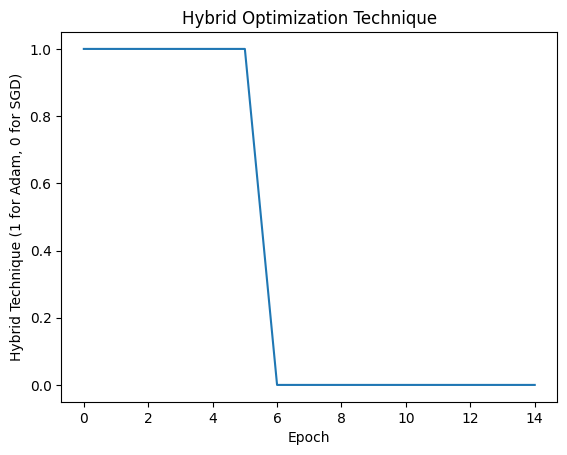

In [ ]:
#adam_sgd
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def hybrid_optimizer(model, params_adam, params_sgd, lr=0.001, momentum=0.9, weight_decay=0.0005, step_size=3, gamma=0.1):
    # Initialize Adam optimizer for initial training
    optimizer_adam = optim.Adam(params_adam, lr=lr, weight_decay=weight_decay)

    # Initialize SGD optimizer for switching
    optimizer_sgd = optim.SGD(params_sgd, lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Learning rate scheduler for SGD optimizer
    lr_scheduler = StepLR(optimizer_sgd, step_size=step_size, gamma=gamma)

    # Initial optimizer
    optimizer = optimizer_adam

    return optimizer, optimizer_adam, optimizer_sgd, lr_scheduler

# Define your model
num_classes = 11
model = get_object_detection_model(num_classes)

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get model parameters for Adam and SGD
params_adam = [p for p in model.parameters() if p.requires_grad]
params_sgd = [p for p in model.parameters() if p.requires_grad]

# Initialize hybrid optimizer
optimizer, optimizer_adam, optimizer_sgd, lr_scheduler = hybrid_optimizer(model, params_adam, params_sgd)

# Training loop
num_epochs = 15
hybrid_results = []  # Initialize list to store hybrid technique values
is_adam = True  # Flag to indicate whether the current optimizer is Adam or not

for epoch in range(num_epochs):
    # Train using current optimizer
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # Append value of hybrid technique
    hybrid_results.append(int(is_adam))  # Append 1 for Adam, 0 for SGD

    # Check a condition to switch to SGD
    if epoch == 5:  # For example, switch to SGD after 5 epochs
        optimizer = optimizer_sgd
        lr_scheduler.step()  # Update learning rate for SGD
        is_adam = False

    # Evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

# Plot the results
plt.plot(hybrid_results)
plt.xlabel('Epoch')
plt.ylabel('Hybrid Technique (1 for Adam, 0 for SGD)')
plt.title('Hybrid Optimization Technique')
plt.show()


In [ ]:
import re

# Define dictionaries to hold your data
metrics = {
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": [],
    "AP": [],           # Add AP metric
    "AP_50": [],        # Add AP_50 metric
    "AP_75": [],        # Add AP_75 metric
    "loss": [],         # Add loss metric
    "loss_classifier": [],  # Add loss_classifier metric
    "loss_box_reg": [],     # Add loss_box_reg metric
    "loss_objectness": [],  # Add loss_objectness metric
    "loss_rpn_box_reg": [],  # Add loss_rpn_box_reg metric
    "model_time": [],        # Add model_time metric
    "evaluator_time": [],    # Add evaluator_time metric
    "total_time": []         # Add total_time metric
}

# Regex patterns to extract data
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_loss = re.compile(r"loss: (\d+\.\d+)")                  # Pattern for loss
pattern_loss_classifier = re.compile(r"loss_classifier: (\d+\.\d+)")  # Pattern for loss_classifier
pattern_loss_box_reg = re.compile(r"loss_box_reg: (\d+\.\d+)")        # Pattern for loss_box_reg
pattern_loss_objectness = re.compile(r"loss_objectness: (\d+\.\d+)")  # Pattern for loss_objectness
pattern_loss_rpn_box_reg = re.compile(r"loss_rpn_box_reg: (\d+\.\d+)")# Pattern for loss_rpn_box_reg
pattern_model_time = re.compile(r"Model time:\s+(\d+\.\d+)")        # Pattern for model_time
pattern_evaluator_time = re.compile(r"Evaluator time:\s+(\d+\.\d+)")# Pattern for evaluator_time
pattern_total_time = re.compile(r"Total time:\s+(\d+\.\d+)")        # Pattern for total_time

# Read the log file
with open('eva adamn_sgd.txt', 'r') as file:
    file_content = file.read()

    # Handling AR matches
    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

    # Handling AP matches
    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])

    # Handling loss matches
    metrics["loss"].extend([float(x) for x in pattern_loss.findall(file_content)])

    # Handling loss_classifier matches
    metrics["loss_classifier"].extend([float(x) for x in pattern_loss_classifier.findall(file_content)])

    # Handling loss_box_reg matches
    metrics["loss_box_reg"].extend([float(x) for x in pattern_loss_box_reg.findall(file_content)])

    # Handling loss_objectness matches
    metrics["loss_objectness"].extend([float(x) for x in pattern_loss_objectness.findall(file_content)])

    # Handling loss_rpn_box_reg matches
    metrics["loss_rpn_box_reg"].extend([float(x) for x in pattern_loss_rpn_box_reg.findall(file_content)])

    # Handling model_time matches
    metrics["model_time"].extend([float(x) for x in pattern_model_time.findall(file_content)])

    # Handling evaluator_time matches
    metrics["evaluator_time"].extend([float(x) for x in pattern_evaluator_time.findall(file_content)])

    # Handling total_time matches
    metrics["total_time"].extend([float(x) for x in pattern_total_time.findall(file_content)])

# Print the collected metrics to verify
for key, value in metrics.items():
    print(f"{key}: {value}")


AR_1: [0.073, 0.007, 0.045, 0.071, 0.105, 0.123, 0.153, 0.157, 0.154, 0.159, 0.153, 0.161, 0.159, 0.166, 0.165]
AR_10: [0.178, 0.056, 0.174, 0.259, 0.315, 0.375, 0.433, 0.442, 0.438, 0.449, 0.447, 0.451, 0.454, 0.455, 0.464]
AR_100: [0.223, 0.101, 0.226, 0.323, 0.371, 0.441, 0.501, 0.506, 0.494, 0.509, 0.509, 0.513, 0.513, 0.517, 0.529]
AR_small: [0.246, 0.115, 0.235, 0.334, 0.35, 0.376, 0.413, 0.434, 0.441, 0.447, 0.455, 0.445, 0.441, 0.45, 0.463]
AR_medium: [0.178, 0.154, 0.278, 0.374, 0.373, 0.504, 0.553, 0.532, 0.533, 0.544, 0.544, 0.55, 0.547, 0.552, 0.569]
AR_large: [0.221, 0.0, 0.09, 0.06, 0.159, 0.237, 0.329, 0.317, 0.307, 0.322, 0.289, 0.339, 0.368, 0.362, 0.375]
AP: [0.098, 0.032, 0.095, 0.173, 0.225, 0.29, 0.347, 0.355, 0.353, 0.361, 0.366, 0.371, 0.372, 0.38, 0.391]
AP_50: []
AP_75: []
loss: [3.3583, 2.3279, 1.209, 0.9238, 0.879, 0.941, 0.8082, 0.6632, 0.5934, 0.8766, 0.7816, 0.6924, 0.5595, 0.9238, 0.9238, 0.8937, 0.8828, 0.8035, 0.7846, 0.7665, 0.7328, 0.8004, 0.8303, 0.8

## **Model Loading**

In [ ]:
import pickle

In [ ]:
Filename = "FRCNNsgd.pkl"

In [ ]:
# Define the file path where you want to save the model
filename = "/content/drive/MyDrive/dataset1/FRCNN1.pth"

# Save the model to the specified file path
torch.save(model.state_dict(), filename)


In [ ]:
# Save the Modle to file in the current working directory
with open(Filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# Load the Model back from file
with open(Filename, 'rb') as file:
    model = pickle.load(file)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## **Validation**

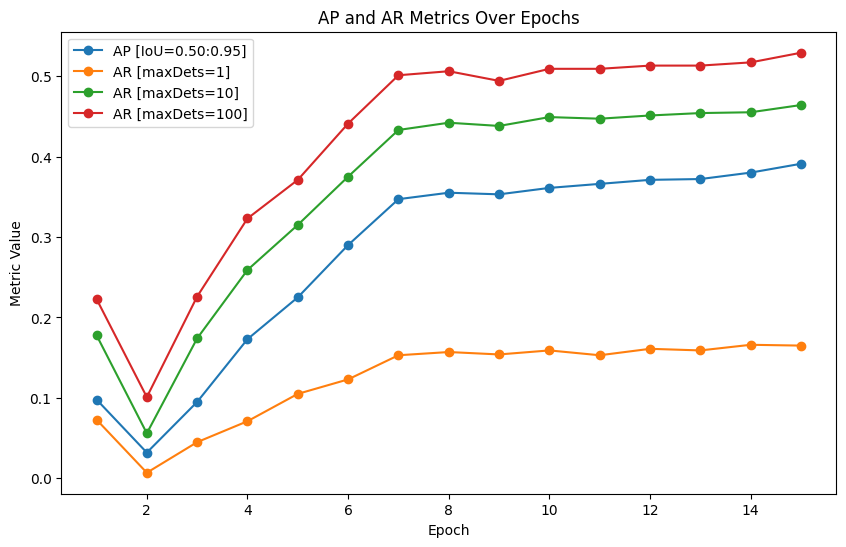

In [ ]:
import matplotlib.pyplot as plt

# Number of epochs or iterations
epochs = list(range(1, len(metrics["AP"]) + 1))

# Create a figure and axis for plotting
plt.figure(figsize=(10, 6))

# Plotting precision metrics
plt.plot(epochs, metrics["AP"], label='AP [IoU=0.50:0.95]', marker='o')

# Plotting recall metrics
plt.plot(epochs, metrics["AR_1"], label='AR [maxDets=1]', marker='o')
plt.plot(epochs, metrics["AR_10"], label='AR [maxDets=10]', marker='o')
plt.plot(epochs, metrics["AR_100"], label='AR [maxDets=100]', marker='o')

# Adding titles and labels
plt.title('AP and AR Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()

# Show the plot
plt.show()


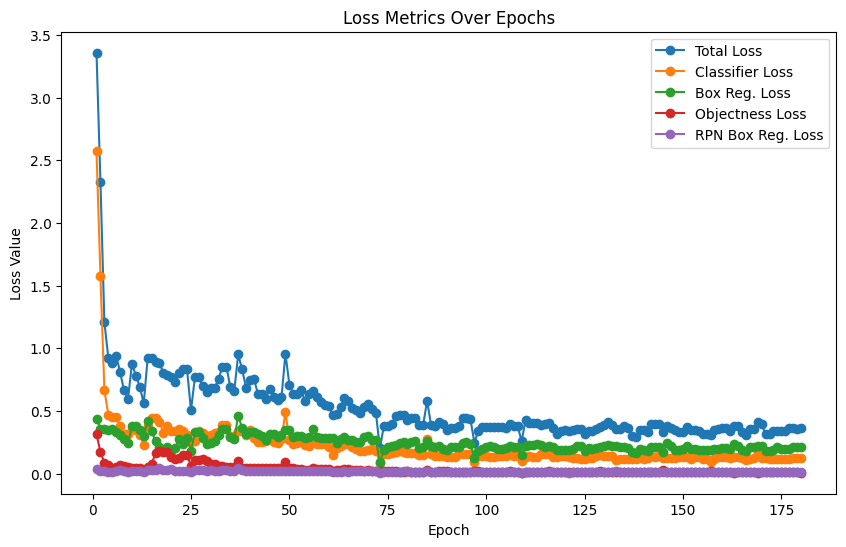

In [ ]:
import matplotlib.pyplot as plt

# Number of epochs or iterations
epochs = list(range(1, len(metrics["loss"]) + 1))

# Create a figure and axis for plotting
plt.figure(figsize=(10, 6))

# Plotting all loss metrics
plt.plot(epochs, metrics["loss"], label='Total Loss', marker='o')
plt.plot(epochs, metrics["loss_classifier"], label='Classifier Loss', marker='o')
plt.plot(epochs, metrics["loss_box_reg"], label='Box Reg. Loss', marker='o')
plt.plot(epochs, metrics["loss_objectness"], label='Objectness Loss', marker='o')
plt.plot(epochs, metrics["loss_rpn_box_reg"], label='RPN Box Reg. Loss', marker='o')

# Adding titles and labels
plt.title('Loss Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import re

# Define dictionaries to hold your data
metrics = {
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": [],
    "AP": [],           # Add AP metric
    "AP_50": [],        # Add AP_50 metric
    "AP_75": [],        # Add AP_75 metric
    "loss": [],         # Add loss metric
    "loss_classifier": [],  # Add loss_classifier metric
    "loss_box_reg": [],     # Add loss_box_reg metric
    "loss_objectness": [],  # Add loss_objectness metric
    "loss_rpn_box_reg": [],  # Add loss_rpn_box_reg metric
    "model_time": [],        # Add model_time metric
    "evaluator_time": [],    # Add evaluator_time metric
    "total_time": []         # Add total_time metric
}

# Regex patterns to extract data
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_loss = re.compile(r"loss: (\d+\.\d+)")                  # Pattern for loss
pattern_loss_classifier = re.compile(r"loss_classifier: (\d+\.\d+)")  # Pattern for loss_classifier
pattern_loss_box_reg = re.compile(r"loss_box_reg: (\d+\.\d+)")        # Pattern for loss_box_reg
pattern_loss_objectness = re.compile(r"loss_objectness: (\d+\.\d+)")  # Pattern for loss_objectness
pattern_loss_rpn_box_reg = re.compile(r"loss_rpn_box_reg: (\d+\.\d+)")# Pattern for loss_rpn_box_reg
pattern_model_time = re.compile(r"Model time:\s+(\d+\.\d+)")        # Pattern for model_time
pattern_evaluator_time = re.compile(r"Evaluator time:\s+(\d+\.\d+)")# Pattern for evaluator_time
pattern_total_time = re.compile(r"Total time:\s+(\d+\.\d+)")        # Pattern for total_time

# Read the log file
with open('eva sgd.txt', 'r') as file:
    file_content = file.read()

    # Handling AR matches
    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

    # Handling AP matches
    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])

    # Handling loss matches
    metrics["loss"].extend([float(x) for x in pattern_loss.findall(file_content)])

    # Handling loss_classifier matches
    metrics["loss_classifier"].extend([float(x) for x in pattern_loss_classifier.findall(file_content)])

    # Handling loss_box_reg matches
    metrics["loss_box_reg"].extend([float(x) for x in pattern_loss_box_reg.findall(file_content)])

    # Handling loss_objectness matches
    metrics["loss_objectness"].extend([float(x) for x in pattern_loss_objectness.findall(file_content)])

    # Handling loss_rpn_box_reg matches
    metrics["loss_rpn_box_reg"].extend([float(x) for x in pattern_loss_rpn_box_reg.findall(file_content)])

    # Handling model_time matches
    metrics["model_time"].extend([float(x) for x in pattern_model_time.findall(file_content)])

    # Handling evaluator_time matches
    metrics["evaluator_time"].extend([float(x) for x in pattern_evaluator_time.findall(file_content)])

    # Handling total_time matches
    metrics["total_time"].extend([float(x) for x in pattern_total_time.findall(file_content)])

# Print the collected metrics to verify
for key, value in metrics.items():
    print(f"{key}: {value}")


AR_1: [0.146, 0.173, 0.196, 0.229, 0.228, 0.234, 0.236, 0.234, 0.235, 0.235, 0.236, 0.236, 0.236, 0.236, 0.236]
AR_10: [0.359, 0.444, 0.471, 0.537, 0.54, 0.544, 0.544, 0.543, 0.543, 0.543, 0.544, 0.544, 0.544, 0.544, 0.544]
AR_100: [0.426, 0.511, 0.528, 0.614, 0.615, 0.61, 0.613, 0.613, 0.614, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615]
AR_small: [0.478, 0.442, 0.49, 0.556, 0.561, 0.541, 0.546, 0.549, 0.547, 0.547, 0.548, 0.548, 0.548, 0.548, 0.548]
AR_medium: [0.405, 0.524, 0.513, 0.596, 0.602, 0.597, 0.599, 0.599, 0.601, 0.601, 0.602, 0.602, 0.602, 0.602, 0.602]
AR_large: [0.515, 0.518, 0.582, 0.663, 0.673, 0.678, 0.685, 0.673, 0.673, 0.673, 0.673, 0.673, 0.673, 0.673, 0.673]
AP: [0.298, 0.404, 0.427, 0.534, 0.54, 0.543, 0.548, 0.547, 0.548, 0.548, 0.548, 0.549, 0.549, 0.549, 0.549]
AP_50: []
AP_75: []
loss: [2.501, 2.1539, 1.2824, 1.1755, 0.9232, 0.903, 0.903, 0.8739, 0.7396, 0.7196, 0.6679, 0.6873, 0.9491, 0.6119, 0.5908, 0.5204, 0.4952, 0.4952, 0.4953, 0.5289, 0.512, 0.5059, 0.4005,

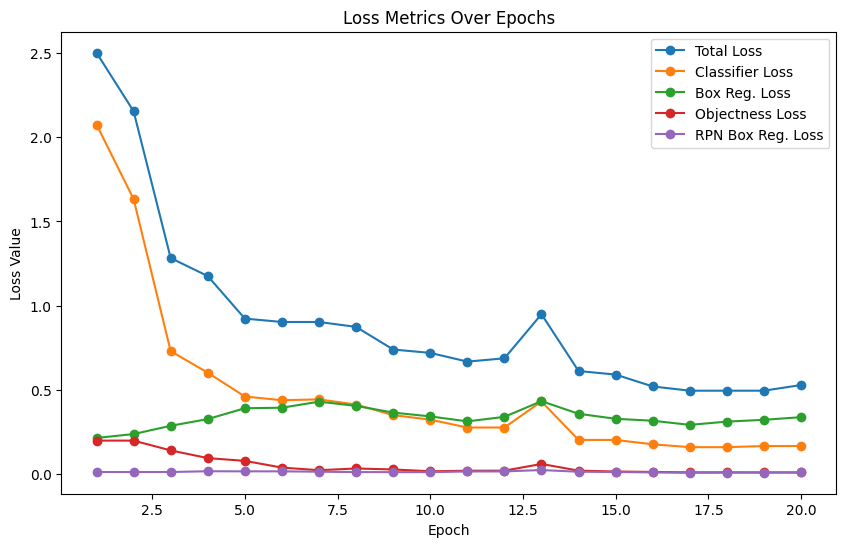

In [ ]:
import matplotlib.pyplot as plt

# Number of epochs or iterations
start_epoch = 1
end_epoch = 20
epochs = list(range(start_epoch, end_epoch + 1))

# Create a figure and axis for plotting
plt.figure(figsize=(10, 6))

# Plotting all loss metrics
plt.plot(epochs, metrics["loss"][:len(epochs)], label='Total Loss', marker='o')
plt.plot(epochs, metrics["loss_classifier"][:len(epochs)], label='Classifier Loss', marker='o')
plt.plot(epochs, metrics["loss_box_reg"][:len(epochs)], label='Box Reg. Loss', marker='o')
plt.plot(epochs, metrics["loss_objectness"][:len(epochs)], label='Objectness Loss', marker='o')
plt.plot(epochs, metrics["loss_rpn_box_reg"][:len(epochs)], label='RPN Box Reg. Loss', marker='o')

# Adding titles and labels
plt.title('Loss Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Show the plot
plt.show()


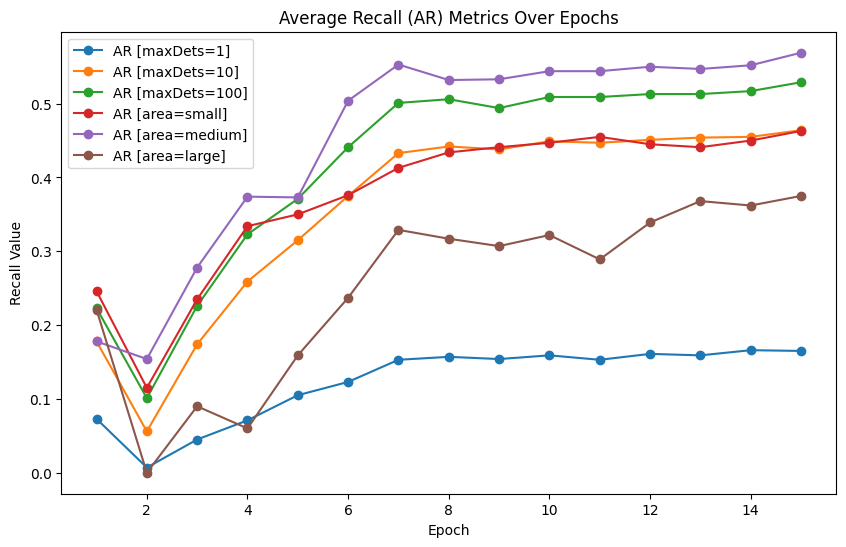

In [ ]:
import matplotlib.pyplot as plt

# Number of epochs or iterations
epochs = list(range(1, len(metrics["AR_1"]) + 1))

# Create a figure and axis for plotting
plt.figure(figsize=(10, 6))

# Plotting recall metrics
plt.plot(epochs, metrics["AR_1"], label='AR [maxDets=1]', marker='o')
plt.plot(epochs, metrics["AR_10"], label='AR [maxDets=10]', marker='o')
plt.plot(epochs, metrics["AR_100"], label='AR [maxDets=100]', marker='o')
plt.plot(epochs, metrics["AR_small"], label='AR [area=small]', marker='o')
plt.plot(epochs, metrics["AR_medium"], label='AR [area=medium]', marker='o')
plt.plot(epochs, metrics["AR_large"], label='AR [area=large]', marker='o')

# Adding titles and labels
plt.title('Average Recall (AR) Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

# Show the plot
plt.show()


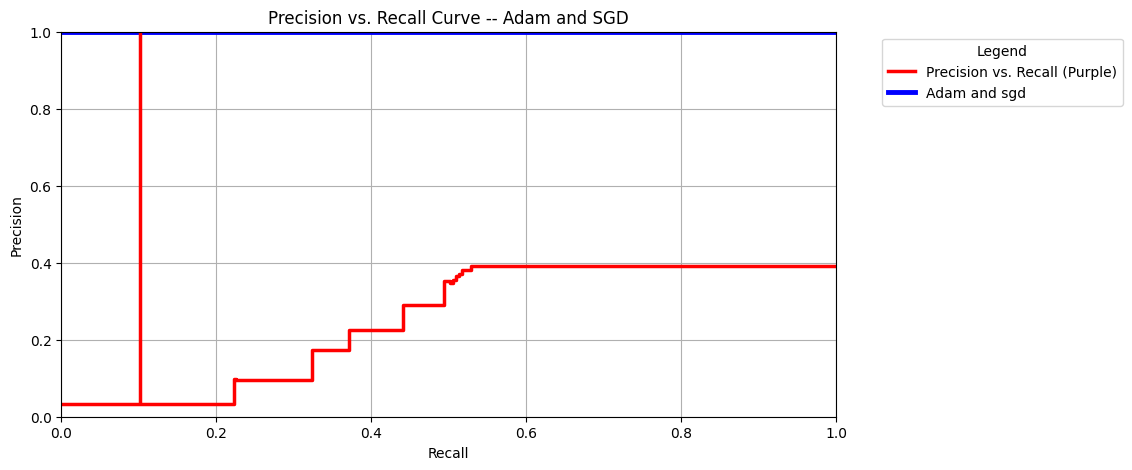

In [ ]:
import matplotlib.pyplot as plt

# Assuming precision_values and recall_values are provided and correctly matched
precision_values = metrics["AP"]  # List of precision values
recall_values = metrics["AR_100"]  # List of recall values corresponding to some IoU or similar metric

# Sort the data by recall since the precision-recall curve expects this.
sorted_indices = sorted(range(len(recall_values)), key=lambda k: recall_values[k])
precision_values = [precision_values[i] for i in sorted_indices]
recall_values = [recall_values[i] for i in sorted_indices]

# To ensure the plot fully spans, check starts and ends
if recall_values[0] > 0:
    recall_values.insert(0, 0)
    precision_values.insert(0, precision_values[0])

if recall_values[-1] < 1:
    recall_values.append(1)
    precision_values.append(precision_values[-1])

# Create the step plot for the precision-recall curve
plt.figure(figsize=(10, 5))
plt.step(recall_values, precision_values, where='post', label='Precision vs. Recall (Purple)', color='red', linewidth=2.5)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Curve -- Adam and SGD')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# Draw a horizontal line at y=1
plt.axhline(y=1, color='blue', linestyle='-', linewidth=3.5, label='Adam and sgd ')

# Draw a vertical purple line from y=1 to the precision at the first recall step
if recall_values[0] == 0:
    first_non_zero_precision = next(p for p in precision_values if p > 0)
    plt.vlines(x=recall_values[1], ymin=1, ymax=first_non_zero_precision, colors='red', linestyles='-', linewidth=2.5)

# Add a legend to clarify line meanings
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
import re

# Define dictionaries to hold your data
metrics = {
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": [],
    "AP": [],           # Add AP metric
    "AP_50": [],        # Add AP_50 metric
    "AP_75": [],        # Add AP_75 metric
    "loss": [],         # Add loss metric
    "loss_classifier": [],  # Add loss_classifier metric
    "loss_box_reg": [],     # Add loss_box_reg metric
    "loss_objectness": [],  # Add loss_objectness metric
    "loss_rpn_box_reg": [],  # Add loss_rpn_box_reg metric
    "model_time": [],        # Add model_time metric
    "evaluator_time": [],    # Add evaluator_time metric
    "total_time": []         # Add total_time metric
}

# Regex patterns to extract data
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_loss = re.compile(r"loss: (\d+\.\d+)")                  # Pattern for loss
pattern_loss_classifier = re.compile(r"loss_classifier: (\d+\.\d+)")  # Pattern for loss_classifier
pattern_loss_box_reg = re.compile(r"loss_box_reg: (\d+\.\d+)")        # Pattern for loss_box_reg
pattern_loss_objectness = re.compile(r"loss_objectness: (\d+\.\d+)")  # Pattern for loss_objectness
pattern_loss_rpn_box_reg = re.compile(r"loss_rpn_box_reg: (\d+\.\d+)")# Pattern for loss_rpn_box_reg
pattern_model_time = re.compile(r"Model time:\s+(\d+\.\d+)")        # Pattern for model_time
pattern_evaluator_time = re.compile(r"Evaluator time:\s+(\d+\.\d+)")# Pattern for evaluator_time
pattern_total_time = re.compile(r"Total time:\s+(\d+\.\d+)")        # Pattern for total_time

# Read the log file
with open('adelta.txt', 'r') as file:
    file_content = file.read()

    # Handling AR matches
    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

    # Handling AP matches
    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])

    # Handling loss matches
    metrics["loss"].extend([float(x) for x in pattern_loss.findall(file_content)])

    # Handling loss_classifier matches
    metrics["loss_classifier"].extend([float(x) for x in pattern_loss_classifier.findall(file_content)])

    # Handling loss_box_reg matches
    metrics["loss_box_reg"].extend([float(x) for x in pattern_loss_box_reg.findall(file_content)])

    # Handling loss_objectness matches
    metrics["loss_objectness"].extend([float(x) for x in pattern_loss_objectness.findall(file_content)])

    # Handling loss_rpn_box_reg matches
    metrics["loss_rpn_box_reg"].extend([float(x) for x in pattern_loss_rpn_box_reg.findall(file_content)])

    # Handling model_time matches
    metrics["model_time"].extend([float(x) for x in pattern_model_time.findall(file_content)])

    # Handling evaluator_time matches
    metrics["evaluator_time"].extend([float(x) for x in pattern_evaluator_time.findall(file_content)])

    # Handling total_time matches
    metrics["total_time"].extend([float(x) for x in pattern_total_time.findall(file_content)])

# Print the collected metrics to verify
for key, value in metrics.items():
    print(f"{key}: {value}")


AR_1: [0.001, 0.006, 0.012, 0.013, 0.012, 0.013, 0.013, 0.013, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014]
AR_10: [0.011, 0.041, 0.077, 0.082, 0.084, 0.085, 0.085, 0.086, 0.086, 0.086, 0.086, 0.086, 0.086, 0.086, 0.086]
AR_100: [0.016, 0.051, 0.104, 0.114, 0.119, 0.122, 0.122, 0.124, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
AR_small: [0.014, 0.107, 0.135, 0.152, 0.14, 0.154, 0.155, 0.156, 0.157, 0.157, 0.15, 0.15, 0.15, 0.15, 0.15]
AR_medium: [0.006, 0.038, 0.139, 0.147, 0.151, 0.154, 0.153, 0.154, 0.155, 0.155, 0.155, 0.155, 0.155, 0.155, 0.155]
AR_large: [0.008, 0.0, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
AP: [0.001, 0.011, 0.025, 0.026, 0.027, 0.028, 0.028, 0.029, 0.029, 0.029, 0.028, 0.028, 0.028, 0.028, 0.028]
AP_50: []
AP_75: []
loss: [4.0759, 3.36, 3.1378, 2.9602, 2.9602, 2.8197, 2.6611, 2.4501, 2.0663, 1.8681, 1.6345, 1.6345, 1.1351, 1.1702, 1.0701, 0.9767, 0.9272, 0.8314, 0.8384, 0.9086, 0.8851, 0.8026, 0.9113, 0

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_Adelta = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_Adelta = metrics["AP"]  # Direct extraction for simplicity in this example

In [ ]:
import re

# Define dictionaries to hold your data
metrics = {
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": [],
    "AP": [],           # Add AP metric
    "AP_50": [],        # Add AP_50 metric
    "AP_75": [],        # Add AP_75 metric
    "loss": [],         # Add loss metric
    "loss_classifier": [],  # Add loss_classifier metric
    "loss_box_reg": [],     # Add loss_box_reg metric
    "loss_objectness": [],  # Add loss_objectness metric
    "loss_rpn_box_reg": [],  # Add loss_rpn_box_reg metric
    "model_time": [],        # Add model_time metric
    "evaluator_time": [],    # Add evaluator_time metric
    "total_time": []         # Add total_time metric
}

# Regex patterns to extract data
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_loss = re.compile(r"loss: (\d+\.\d+)")                  # Pattern for loss
pattern_loss_classifier = re.compile(r"loss_classifier: (\d+\.\d+)")  # Pattern for loss_classifier
pattern_loss_box_reg = re.compile(r"loss_box_reg: (\d+\.\d+)")        # Pattern for loss_box_reg
pattern_loss_objectness = re.compile(r"loss_objectness: (\d+\.\d+)")  # Pattern for loss_objectness
pattern_loss_rpn_box_reg = re.compile(r"loss_rpn_box_reg: (\d+\.\d+)")# Pattern for loss_rpn_box_reg
pattern_model_time = re.compile(r"Model time:\s+(\d+\.\d+)")        # Pattern for model_time
pattern_evaluator_time = re.compile(r"Evaluator time:\s+(\d+\.\d+)")# Pattern for evaluator_time
pattern_total_time = re.compile(r"Total time:\s+(\d+\.\d+)")        # Pattern for total_time

# Read the log file
with open('eva adam.txt', 'r') as file:
    file_content = file.read()

    # Handling AR matches
    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

    # Handling AP matches
    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])

    # Handling loss matches
    metrics["loss"].extend([float(x) for x in pattern_loss.findall(file_content)])

    # Handling loss_classifier matches
    metrics["loss_classifier"].extend([float(x) for x in pattern_loss_classifier.findall(file_content)])

    # Handling loss_box_reg matches
    metrics["loss_box_reg"].extend([float(x) for x in pattern_loss_box_reg.findall(file_content)])

    # Handling loss_objectness matches
    metrics["loss_objectness"].extend([float(x) for x in pattern_loss_objectness.findall(file_content)])

    # Handling loss_rpn_box_reg matches
    metrics["loss_rpn_box_reg"].extend([float(x) for x in pattern_loss_rpn_box_reg.findall(file_content)])

    # Handling model_time matches
    metrics["model_time"].extend([float(x) for x in pattern_model_time.findall(file_content)])

    # Handling evaluator_time matches
    metrics["evaluator_time"].extend([float(x) for x in pattern_evaluator_time.findall(file_content)])

    # Handling total_time matches
    metrics["total_time"].extend([float(x) for x in pattern_total_time.findall(file_content)])

# Print the collected metrics to verify
for key, value in metrics.items():
    print(f"{key}: {value}")


AR_1: [0.06, 0.108, 0.111, 0.176, 0.193, 0.192, 0.208, 0.21, 0.21, 0.21, 0.213, 0.215, 0.216, 0.216, 0.216]
AR_10: [0.138, 0.303, 0.311, 0.483, 0.492, 0.501, 0.518, 0.518, 0.522, 0.519, 0.523, 0.524, 0.524, 0.524, 0.524]
AR_100: [0.18, 0.351, 0.356, 0.545, 0.552, 0.558, 0.576, 0.576, 0.576, 0.574, 0.578, 0.579, 0.58, 0.58, 0.58]
AR_small: [0.206, 0.316, 0.289, 0.438, 0.422, 0.448, 0.444, 0.444, 0.445, 0.447, 0.447, 0.448, 0.448, 0.448, 0.448]
AR_medium: [0.199, 0.396, 0.416, 0.588, 0.599, 0.606, 0.623, 0.63, 0.629, 0.622, 0.626, 0.628, 0.629, 0.629, 0.629]
AR_large: [0.088, 0.183, 0.246, 0.441, 0.487, 0.47, 0.492, 0.513, 0.528, 0.518, 0.532, 0.523, 0.523, 0.523, 0.523]
AP: [0.086, 0.209, 0.212, 0.408, 0.429, 0.452, 0.478, 0.482, 0.483, 0.485, 0.488, 0.49, 0.491, 0.491, 0.491]
AP_50: []
AP_75: []
loss: [3.4412, 1.9666, 1.0744, 0.8417, 0.8124, 0.8505, 0.9567, 0.8243, 0.8379, 0.8269, 0.7398, 0.7319, 0.8187, 0.626, 0.6369, 0.6915, 0.7575, 0.7855, 0.7067, 0.6577, 0.602, 0.5815, 0.6848, 0.58

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_Adam = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_Adam = metrics["AP"]  # Direct extraction for simplicity in this example

In [ ]:
import re

# Define dictionaries to hold your data
metrics = {
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": [],
    "AP": [],           # Add AP metric
    "AP_50": [],        # Add AP_50 metric
    "AP_75": [],        # Add AP_75 metric
    "loss": [],         # Add loss metric
    "loss_classifier": [],  # Add loss_classifier metric
    "loss_box_reg": [],     # Add loss_box_reg metric
    "loss_objectness": [],  # Add loss_objectness metric
    "loss_rpn_box_reg": [],  # Add loss_rpn_box_reg metric
    "model_time": [],        # Add model_time metric
    "evaluator_time": [],    # Add evaluator_time metric
    "total_time": []         # Add total_time metric
}

# Regex patterns to extract data
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_loss = re.compile(r"loss: (\d+\.\d+)")                  # Pattern for loss
pattern_loss_classifier = re.compile(r"loss_classifier: (\d+\.\d+)")  # Pattern for loss_classifier
pattern_loss_box_reg = re.compile(r"loss_box_reg: (\d+\.\d+)")        # Pattern for loss_box_reg
pattern_loss_objectness = re.compile(r"loss_objectness: (\d+\.\d+)")  # Pattern for loss_objectness
pattern_loss_rpn_box_reg = re.compile(r"loss_rpn_box_reg: (\d+\.\d+)")# Pattern for loss_rpn_box_reg
pattern_model_time = re.compile(r"Model time:\s+(\d+\.\d+)")        # Pattern for model_time
pattern_evaluator_time = re.compile(r"Evaluator time:\s+(\d+\.\d+)")# Pattern for evaluator_time
pattern_total_time = re.compile(r"Total time:\s+(\d+\.\d+)")        # Pattern for total_time

# Read the log file
with open('eva adamn_sgd.txt', 'r') as file:
    file_content = file.read()

    # Handling AR matches
    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

    # Handling AP matches
    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])

    # Handling loss matches
    metrics["loss"].extend([float(x) for x in pattern_loss.findall(file_content)])

    # Handling loss_classifier matches
    metrics["loss_classifier"].extend([float(x) for x in pattern_loss_classifier.findall(file_content)])

    # Handling loss_box_reg matches
    metrics["loss_box_reg"].extend([float(x) for x in pattern_loss_box_reg.findall(file_content)])

    # Handling loss_objectness matches
    metrics["loss_objectness"].extend([float(x) for x in pattern_loss_objectness.findall(file_content)])

    # Handling loss_rpn_box_reg matches
    metrics["loss_rpn_box_reg"].extend([float(x) for x in pattern_loss_rpn_box_reg.findall(file_content)])

    # Handling model_time matches
    metrics["model_time"].extend([float(x) for x in pattern_model_time.findall(file_content)])

    # Handling evaluator_time matches
    metrics["evaluator_time"].extend([float(x) for x in pattern_evaluator_time.findall(file_content)])

    # Handling total_time matches
    metrics["total_time"].extend([float(x) for x in pattern_total_time.findall(file_content)])

# Print the collected metrics to verify
for key, value in metrics.items():
    print(f"{key}: {value}")


AR_1: [0.073, 0.007, 0.045, 0.071, 0.105, 0.123, 0.153, 0.157, 0.154, 0.159, 0.153, 0.161, 0.159, 0.166, 0.165]
AR_10: [0.178, 0.056, 0.174, 0.259, 0.315, 0.375, 0.433, 0.442, 0.438, 0.449, 0.447, 0.451, 0.454, 0.455, 0.464]
AR_100: [0.223, 0.101, 0.226, 0.323, 0.371, 0.441, 0.501, 0.506, 0.494, 0.509, 0.509, 0.513, 0.513, 0.517, 0.529]
AR_small: [0.246, 0.115, 0.235, 0.334, 0.35, 0.376, 0.413, 0.434, 0.441, 0.447, 0.455, 0.445, 0.441, 0.45, 0.463]
AR_medium: [0.178, 0.154, 0.278, 0.374, 0.373, 0.504, 0.553, 0.532, 0.533, 0.544, 0.544, 0.55, 0.547, 0.552, 0.569]
AR_large: [0.221, 0.0, 0.09, 0.06, 0.159, 0.237, 0.329, 0.317, 0.307, 0.322, 0.289, 0.339, 0.368, 0.362, 0.375]
AP: [0.098, 0.032, 0.095, 0.173, 0.225, 0.29, 0.347, 0.355, 0.353, 0.361, 0.366, 0.371, 0.372, 0.38, 0.391]
AP_50: []
AP_75: []
loss: [3.3583, 2.3279, 1.209, 0.9238, 0.879, 0.941, 0.8082, 0.6632, 0.5934, 0.8766, 0.7816, 0.6924, 0.5595, 0.9238, 0.9238, 0.8937, 0.8828, 0.8035, 0.7846, 0.7665, 0.7328, 0.8004, 0.8303, 0.8

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_ADAMNSGD = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_ADAMNSGD = metrics["AP"]  # Direct extraction for simplicity in this example

In [ ]:
import re

# Define dictionaries to hold your data
metrics = {
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": [],
    "AP": [],           # Add AP metric
    "AP_50": [],        # Add AP_50 metric
    "AP_75": [],        # Add AP_75 metric
    "loss": [],         # Add loss metric
    "loss_classifier": [],  # Add loss_classifier metric
    "loss_box_reg": [],     # Add loss_box_reg metric
    "loss_objectness": [],  # Add loss_objectness metric
    "loss_rpn_box_reg": [],  # Add loss_rpn_box_reg metric
    "model_time": [],        # Add model_time metric
    "evaluator_time": [],    # Add evaluator_time metric
    "total_time": []         # Add total_time metric
}

# Regex patterns to extract data
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_loss = re.compile(r"loss: (\d+\.\d+)")                  # Pattern for loss
pattern_loss_classifier = re.compile(r"loss_classifier: (\d+\.\d+)")  # Pattern for loss_classifier
pattern_loss_box_reg = re.compile(r"loss_box_reg: (\d+\.\d+)")        # Pattern for loss_box_reg
pattern_loss_objectness = re.compile(r"loss_objectness: (\d+\.\d+)")  # Pattern for loss_objectness
pattern_loss_rpn_box_reg = re.compile(r"loss_rpn_box_reg: (\d+\.\d+)")# Pattern for loss_rpn_box_reg
pattern_model_time = re.compile(r"Model time:\s+(\d+\.\d+)")        # Pattern for model_time
pattern_evaluator_time = re.compile(r"Evaluator time:\s+(\d+\.\d+)")# Pattern for evaluator_time
pattern_total_time = re.compile(r"Total time:\s+(\d+\.\d+)")        # Pattern for total_time

# Read the log file
with open('eva rsmprob.txt', 'r') as file:
    file_content = file.read()

    # Handling AR matches
    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

    # Handling AP matches
    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])

    # Handling loss matches
    metrics["loss"].extend([float(x) for x in pattern_loss.findall(file_content)])

    # Handling loss_classifier matches
    metrics["loss_classifier"].extend([float(x) for x in pattern_loss_classifier.findall(file_content)])

    # Handling loss_box_reg matches
    metrics["loss_box_reg"].extend([float(x) for x in pattern_loss_box_reg.findall(file_content)])

    # Handling loss_objectness matches
    metrics["loss_objectness"].extend([float(x) for x in pattern_loss_objectness.findall(file_content)])

    # Handling loss_rpn_box_reg matches
    metrics["loss_rpn_box_reg"].extend([float(x) for x in pattern_loss_rpn_box_reg.findall(file_content)])

    # Handling model_time matches
    metrics["model_time"].extend([float(x) for x in pattern_model_time.findall(file_content)])

    # Handling evaluator_time matches
    metrics["evaluator_time"].extend([float(x) for x in pattern_evaluator_time.findall(file_content)])

    # Handling total_time matches
    metrics["total_time"].extend([float(x) for x in pattern_total_time.findall(file_content)])

# Print the collected metrics to verify
for key, value in metrics.items():
    print(f"{key}: {value}")


AR_1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AR_10: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AR_100: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AR_small: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AR_medium: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AR_large: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AP: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AP_50: []
AP_75: []
loss: [3.2039, 1.2988, 1.2517, 1.0549, 1.3226, 2.6148, 2.235, 0.9199, 0.6987, 0.5503, 0.6267, 0.6827, 1.452, 258.9862, 5199.8223, 2652.1675, 1029.4604, 660.6842, 426.3805, 1013.4094, 840.2881, 199.0619, 2028.7905, 2464.8901, 3665.436, 1106.7623, 472.3109, 121.1059, 133.583, 273.1735, 365.2442, 594.5722, 490.288, 517.9962, 480.0167, 315.5242, 304.2431, 272.1476, 265.4117, 169.659, 148.1319,

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_RMSprop = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_RMSprop = metrics["AP"]  # Direct extraction for simplicity in this example

In [ ]:
import re

# Define dictionaries to hold your data
metrics = {
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": [],
    "AP": [],           # Add AP metric
    "AP_50": [],        # Add AP_50 metric
    "AP_75": [],        # Add AP_75 metric
    "loss": [],         # Add loss metric
    "loss_classifier": [],  # Add loss_classifier metric
    "loss_box_reg": [],     # Add loss_box_reg metric
    "loss_objectness": [],  # Add loss_objectness metric
    "loss_rpn_box_reg": [],  # Add loss_rpn_box_reg metric
    "model_time": [],        # Add model_time metric
    "evaluator_time": [],    # Add evaluator_time metric
    "total_time": []         # Add total_time metric
}

# Regex patterns to extract data
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_loss = re.compile(r"loss: (\d+\.\d+)")                  # Pattern for loss
pattern_loss_classifier = re.compile(r"loss_classifier: (\d+\.\d+)")  # Pattern for loss_classifier
pattern_loss_box_reg = re.compile(r"loss_box_reg: (\d+\.\d+)")        # Pattern for loss_box_reg
pattern_loss_objectness = re.compile(r"loss_objectness: (\d+\.\d+)")  # Pattern for loss_objectness
pattern_loss_rpn_box_reg = re.compile(r"loss_rpn_box_reg: (\d+\.\d+)")# Pattern for loss_rpn_box_reg
pattern_model_time = re.compile(r"Model time:\s+(\d+\.\d+)")        # Pattern for model_time
pattern_evaluator_time = re.compile(r"Evaluator time:\s+(\d+\.\d+)")# Pattern for evaluator_time
pattern_total_time = re.compile(r"Total time:\s+(\d+\.\d+)")        # Pattern for total_time

# Read the log file
with open('eva sgd.txt', 'r') as file:
    file_content = file.read()

    # Handling AR matches
    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

    # Handling AP matches
    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])

    # Handling loss matches
    metrics["loss"].extend([float(x) for x in pattern_loss.findall(file_content)])

    # Handling loss_classifier matches
    metrics["loss_classifier"].extend([float(x) for x in pattern_loss_classifier.findall(file_content)])

    # Handling loss_box_reg matches
    metrics["loss_box_reg"].extend([float(x) for x in pattern_loss_box_reg.findall(file_content)])

    # Handling loss_objectness matches
    metrics["loss_objectness"].extend([float(x) for x in pattern_loss_objectness.findall(file_content)])

    # Handling loss_rpn_box_reg matches
    metrics["loss_rpn_box_reg"].extend([float(x) for x in pattern_loss_rpn_box_reg.findall(file_content)])

    # Handling model_time matches
    metrics["model_time"].extend([float(x) for x in pattern_model_time.findall(file_content)])

    # Handling evaluator_time matches
    metrics["evaluator_time"].extend([float(x) for x in pattern_evaluator_time.findall(file_content)])

    # Handling total_time matches
    metrics["total_time"].extend([float(x) for x in pattern_total_time.findall(file_content)])

# Print the collected metrics to verify
for key, value in metrics.items():
    print(f"{key}: {value}")


AR_1: [0.146, 0.173, 0.196, 0.229, 0.228, 0.234, 0.236, 0.234, 0.235, 0.235, 0.236, 0.236, 0.236, 0.236, 0.236]
AR_10: [0.359, 0.444, 0.471, 0.537, 0.54, 0.544, 0.544, 0.543, 0.543, 0.543, 0.544, 0.544, 0.544, 0.544, 0.544]
AR_100: [0.426, 0.511, 0.528, 0.614, 0.615, 0.61, 0.613, 0.613, 0.614, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615]
AR_small: [0.478, 0.442, 0.49, 0.556, 0.561, 0.541, 0.546, 0.549, 0.547, 0.547, 0.548, 0.548, 0.548, 0.548, 0.548]
AR_medium: [0.405, 0.524, 0.513, 0.596, 0.602, 0.597, 0.599, 0.599, 0.601, 0.601, 0.602, 0.602, 0.602, 0.602, 0.602]
AR_large: [0.515, 0.518, 0.582, 0.663, 0.673, 0.678, 0.685, 0.673, 0.673, 0.673, 0.673, 0.673, 0.673, 0.673, 0.673]
AP: [0.298, 0.404, 0.427, 0.534, 0.54, 0.543, 0.548, 0.547, 0.548, 0.548, 0.548, 0.549, 0.549, 0.549, 0.549]
AP_50: []
AP_75: []
loss: [2.501, 2.1539, 1.2824, 1.1755, 0.9232, 0.903, 0.903, 0.8739, 0.7396, 0.7196, 0.6679, 0.6873, 0.9491, 0.6119, 0.5908, 0.5204, 0.4952, 0.4952, 0.4953, 0.5289, 0.512, 0.5059, 0.4005,

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_SGD = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_SGD = metrics["AP"]  # Direct extraction for simplicity in this example

In [ ]:
import re

# Define dictionaries to hold your data
metrics = {
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": [],
    "AP": [],           # Add AP metric
    "AP_50": [],        # Add AP_50 metric
    "AP_75": [],        # Add AP_75 metric
    "loss": [],         # Add loss metric
    "loss_classifier": [],  # Add loss_classifier metric
    "loss_box_reg": [],     # Add loss_box_reg metric
    "loss_objectness": [],  # Add loss_objectness metric
    "loss_rpn_box_reg": [],  # Add loss_rpn_box_reg metric
    "model_time": [],        # Add model_time metric
    "evaluator_time": [],    # Add evaluator_time metric
    "total_time": []         # Add total_time metric
}

# Regex patterns to extract data
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_loss = re.compile(r"loss: (\d+\.\d+)")                  # Pattern for loss
pattern_loss_classifier = re.compile(r"loss_classifier: (\d+\.\d+)")  # Pattern for loss_classifier
pattern_loss_box_reg = re.compile(r"loss_box_reg: (\d+\.\d+)")        # Pattern for loss_box_reg
pattern_loss_objectness = re.compile(r"loss_objectness: (\d+\.\d+)")  # Pattern for loss_objectness
pattern_loss_rpn_box_reg = re.compile(r"loss_rpn_box_reg: (\d+\.\d+)")# Pattern for loss_rpn_box_reg
pattern_model_time = re.compile(r"Model time:\s+(\d+\.\d+)")        # Pattern for model_time
pattern_evaluator_time = re.compile(r"Evaluator time:\s+(\d+\.\d+)")# Pattern for evaluator_time
pattern_total_time = re.compile(r"Total time:\s+(\d+\.\d+)")        # Pattern for total_time

# Read the log file
with open('eva-sgd-adam.txt', 'r') as file:
    file_content = file.read()

    # Handling AR matches
    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

    # Handling AP matches
    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])

    # Handling loss matches
    metrics["loss"].extend([float(x) for x in pattern_loss.findall(file_content)])

    # Handling loss_classifier matches
    metrics["loss_classifier"].extend([float(x) for x in pattern_loss_classifier.findall(file_content)])

    # Handling loss_box_reg matches
    metrics["loss_box_reg"].extend([float(x) for x in pattern_loss_box_reg.findall(file_content)])

    # Handling loss_objectness matches
    metrics["loss_objectness"].extend([float(x) for x in pattern_loss_objectness.findall(file_content)])

    # Handling loss_rpn_box_reg matches
    metrics["loss_rpn_box_reg"].extend([float(x) for x in pattern_loss_rpn_box_reg.findall(file_content)])

    # Handling model_time matches
    metrics["model_time"].extend([float(x) for x in pattern_model_time.findall(file_content)])

    # Handling evaluator_time matches
    metrics["evaluator_time"].extend([float(x) for x in pattern_evaluator_time.findall(file_content)])

    # Handling total_time matches
    metrics["total_time"].extend([float(x) for x in pattern_total_time.findall(file_content)])

# Print the collected metrics to verify
for key, value in metrics.items():
    print(f"{key}: {value}")


AR_1: [0.155, 0.176, 0.212, 0.201, 0.223, 0.21, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AR_10: [0.361, 0.44, 0.491, 0.492, 0.536, 0.516, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AR_100: [0.417, 0.523, 0.561, 0.573, 0.615, 0.59, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AR_small: [0.397, 0.468, 0.518, 0.549, 0.558, 0.564, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AR_medium: [0.401, 0.529, 0.536, 0.559, 0.612, 0.575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AR_large: [0.512, 0.525, 0.661, 0.591, 0.678, 0.681, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AP: [0.301, 0.41, 0.462, 0.501, 0.529, 0.515, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AP_50: []
AP_75: []
loss: [2.4863, 2.3532, 1.1952, 0.9789, 0.9841, 1.1299, 0.9868, 0.8872, 0.7456, 0.6964, 0.6284, 0.6043, 0.4607, 0.4607, 0.5609, 0.4909, 0.47, 0.4464, 0.443, 0.3735, 0.3686, 0.4321, 0.4684, 0.4684, 0.3919, 0.3873, 0.3873, 0.3953, 0.3284, 0.2966, 0.2966, 0.3423, 0.3673, 0.3673, 0.3391, 0.3387, 0.3369, 0.2875, 0.28

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_SGDADAMN = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_SGDADAMN = metrics["AP"]  # Direct extraction for simplicity in this example

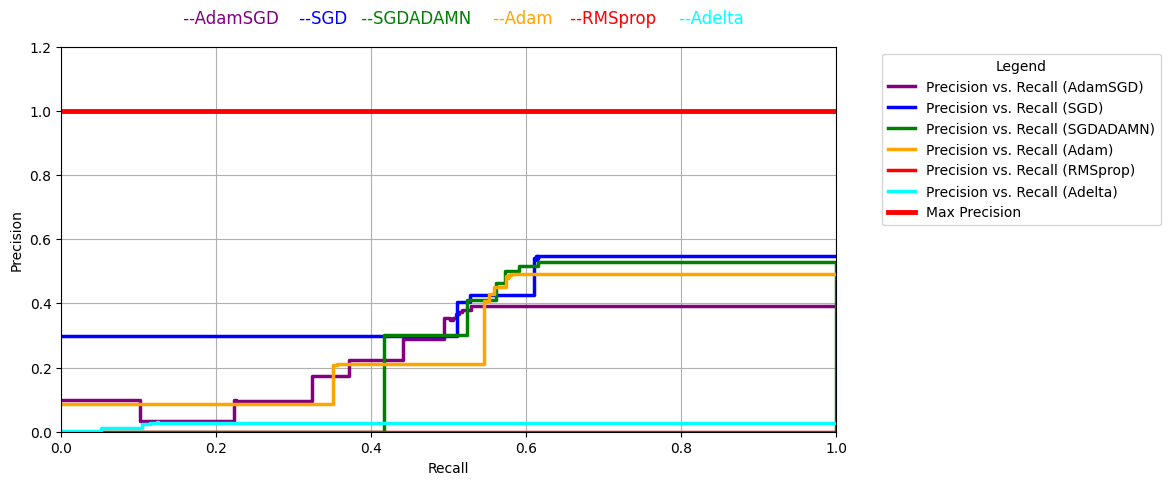

In [ ]:
import matplotlib.pyplot as plt

# Sort the data by recall since the precision-recall curve expects this.
sorted_indices_ADAMNSGD = sorted(range(len(recall_values_ADAMNSGD)), key=lambda k: recall_values_ADAMNSGD[k])
precision_values_ADAMNSGD_sorted = [precision_values_ADAMNSGD[i] for i in sorted_indices_ADAMNSGD]
recall_values_ADAMNSGD_sorted = [recall_values_ADAMNSGD[i] for i in sorted_indices_ADAMNSGD]

# To ensure the plot fully spans, check starts and ends
if recall_values_ADAMNSGD_sorted[0] > 0:
    recall_values_ADAMNSGD_sorted.insert(0, 0)
    precision_values_ADAMNSGD_sorted.insert(0, precision_values_ADAMNSGD[0])

if recall_values_ADAMNSGD_sorted[-1] < 1:
    recall_values_ADAMNSGD_sorted.append(1)
    precision_values_ADAMNSGD_sorted.append(precision_values_ADAMNSGD[-1])

# Sort the data for SGD since the precision-recall curve expects this.
sorted_indices_SGD = sorted(range(len(recall_values_SGD)), key=lambda k: recall_values_SGD[k])
precision_values_SGD_sorted = [precision_values_SGD[i] for i in sorted_indices_SGD]
recall_values_SGD_sorted = [recall_values_SGD[i] for i in sorted_indices_SGD]

# To ensure the plot fully spans, check starts and ends
if recall_values_SGD_sorted[0] > 0:
    recall_values_SGD_sorted.insert(0, 0)
    precision_values_SGD_sorted.insert(0, precision_values_SGD[0])

if recall_values_SGD_sorted[-1] < 1:
    recall_values_SGD_sorted.append(1)
    precision_values_SGD_sorted.append(precision_values_SGD[-1])

# Sort the data for SGDADAMN since the precision-recall curve expects this.
sorted_indices_SGDADAMN = sorted(range(len(recall_values_SGDADAMN)), key=lambda k: recall_values_SGDADAMN[k])
precision_values_SGDADAMN_sorted = [precision_values_SGDADAMN[i] for i in sorted_indices_SGDADAMN]
recall_values_SGDADAMN_sorted = [recall_values_SGDADAMN[i] for i in sorted_indices_SGDADAMN]

# To ensure the plot fully spans, check starts and ends
if recall_values_SGDADAMN_sorted[0] > 0:
    recall_values_SGDADAMN_sorted.insert(0, 0)
    precision_values_SGDADAMN_sorted.insert(0, precision_values_SGDADAMN[0])

if recall_values_SGDADAMN_sorted[-1] < 1:
    recall_values_SGDADAMN_sorted.append(1)
    precision_values_SGDADAMN_sorted.append(precision_values_SGDADAMN[-1])

# Sort the data for Adam since the precision-recall curve expects this.
sorted_indices_Adam = sorted(range(len(recall_values_Adam)), key=lambda k: recall_values_Adam[k])
precision_values_Adam_sorted = [precision_values_Adam[i] for i in sorted_indices_Adam]
recall_values_Adam_sorted = [recall_values_Adam[i] for i in sorted_indices_Adam]

# To ensure the plot fully spans, check starts and ends
if recall_values_Adam_sorted[0] > 0:
    recall_values_Adam_sorted.insert(0, 0)
    precision_values_Adam_sorted.insert(0, precision_values_Adam[0])

if recall_values_Adam_sorted[-1] < 1:
    recall_values_Adam_sorted.append(1)
    precision_values_Adam_sorted.append(precision_values_Adam[-1])

# Sort the data for RMSprop since the precision-recall curve expects this.
sorted_indices_RMSprop = sorted(range(len(recall_values_RMSprop)), key=lambda k: recall_values_RMSprop[k])
precision_values_RMSprop_sorted = [precision_values_RMSprop[i] for i in sorted_indices_RMSprop]
recall_values_RMSprop_sorted = [recall_values_RMSprop[i] for i in sorted_indices_RMSprop]

# To ensure the plot fully spans, check starts and ends
if recall_values_RMSprop_sorted[0] > 0:
    recall_values_RMSprop_sorted.insert(0, 0)
    precision_values_RMSprop_sorted.insert(0, precision_values_RMSprop[0])

if recall_values_RMSprop_sorted[-1] < 1:
    recall_values_RMSprop_sorted.append(1)
    precision_values_RMSprop_sorted.append(precision_values_RMSprop[-1])

# Sort the data for Adelta since the precision-recall curve expects this.
sorted_indices_Adelta = sorted(range(len(recall_values_Adelta)), key=lambda k: recall_values_Adelta[k])
precision_values_Adelta_sorted = [precision_values_Adelta[i] for i in sorted_indices_Adelta]
recall_values_Adelta_sorted = [recall_values_Adelta[i] for i in sorted_indices_Adelta]

# To ensure the plot fully spans, check starts and ends
if recall_values_Adelta_sorted[0] > 0:
    recall_values_Adelta_sorted.insert(0, 0)
    precision_values_Adelta_sorted.insert(0, precision_values_Adelta[0])

if recall_values_Adelta_sorted[-1] < 1:
    recall_values_Adelta_sorted.append(1)
    precision_values_Adelta_sorted.append(precision_values_Adelta[-1])

# Create the step plot for the precision-recall curve
plt.figure(figsize=(10, 5))

# Plot for AdamSGD
plt.step(recall_values_ADAMNSGD_sorted, precision_values_ADAMNSGD_sorted, where='post', color='purple', linewidth=2.5, label='Precision vs. Recall (AdamSGD)')

# Plot for SGD
plt.step(recall_values_SGD_sorted, precision_values_SGD_sorted, where='post', color='blue', linewidth=2.5, label='Precision vs. Recall (SGD)')

# Plot for SGDADAMN
plt.step(recall_values_SGDADAMN_sorted, precision_values_SGDADAMN_sorted, where='post', color='green', linewidth=2.5, label='Precision vs. Recall (SGDADAMN)')

# Plot for Adam
plt.step(recall_values_Adam_sorted, precision_values_Adam_sorted, where='post', color='orange', linewidth=2.5, label='Precision vs. Recall (Adam)')

# Plot for RMSprop
plt.step(recall_values_RMSprop_sorted, precision_values_RMSprop_sorted, where='post', color='red', linewidth=2.5, label='Precision vs. Recall (RMSprop)')

# Plot for Adelta
plt.step(recall_values_Adelta_sorted, precision_values_Adelta_sorted, where='post', color='cyan', linewidth=2.5, label='Precision vs. Recall (Adelta)')

# Customize the plot
plt.xlabel('Recall')
plt.ylabel('Precision')

# Title for AdamSGD
plt.text(0.15, 1.05, ' --AdamSGD', color='purple', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for SGD
plt.text(0.30, 1.05, ' --SGD', color='blue', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for SGDADAMN
plt.text(0.38, 1.05, ' --SGDADAMN', color='green', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for Adam
plt.text(0.55, 1.05, ' --Adam', color='orange', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for RMSprop
plt.text(0.65, 1.05, ' --RMSprop', color='red', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for Adelta
plt.text(0.79, 1.05, ' --Adelta', color='cyan', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)


plt.xlim(0, 1)
plt.ylim(0, 1.2)
plt.grid(True)

# Draw a horizontal line at y=1
plt.axhline(y=1, color='red', linestyle='-', linewidth=3.5, label='Max Precision')

# Enhance the legend to include stylistic references
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

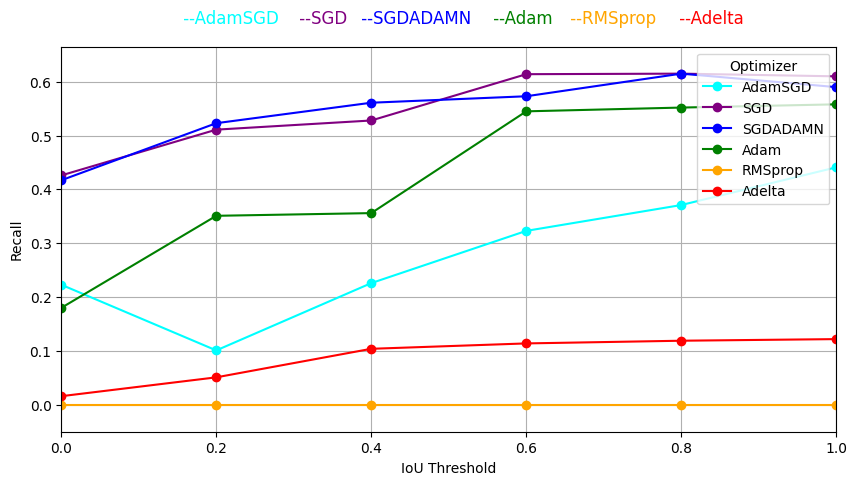

In [ ]:
import matplotlib.pyplot as plt

# Define the IoU thresholds from 0 to 1 with an increment of 0.2
iou_thresholds = [i / 5 for i in range(6)]

# Your provided recall values. Assuming each array has more than 6 elements, slice to the first 6.
recall_values_ADAMNSGD = recall_values_ADAMNSGD[:6]  # Slice to the first 6 values
recall_values_SGD = recall_values_SGD[:6]            # Slice to the first 6 values
recall_values_SGDADAMN = recall_values_SGDADAMN[:6]  # Slice to the first 6 values
recall_values_Adam = recall_values_Adam[:6]          # Slice to the first 6 values
recall_values_RMSprop = recall_values_RMSprop[:6]    # Slice to the first 6 values
recall_values_Adelta = recall_values_Adelta[:6]      # Slice to the first 6 values

plt.figure(figsize=(10, 5))

# Plot each optimizer with points marked by 'o'
plt.plot(iou_thresholds, recall_values_ADAMNSGD, marker='o', linestyle='-', color='cyan', label='AdamSGD')
plt.plot(iou_thresholds, recall_values_SGD, marker='o', linestyle='-', color='purple', label='SGD')
plt.plot(iou_thresholds, recall_values_SGDADAMN, marker='o', linestyle='-', color='blue', label='SGDADAMN')
plt.plot(iou_thresholds, recall_values_Adam, marker='o', linestyle='-', color='green', label='Adam')
plt.plot(iou_thresholds, recall_values_RMSprop, marker='o', linestyle='-', color='orange', label='RMSprop')
plt.plot(iou_thresholds, recall_values_Adelta, marker='o', linestyle='-', color='red', label='Adelta')

# Title for AdamSGD
plt.text(0.15, 1.05, ' --AdamSGD', color='cyan', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for SGD
plt.text(0.30, 1.05, ' --SGD', color='purple', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for SGDADAMN
plt.text(0.38, 1.05, ' --SGDADAMN', color='blue', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for Adam
plt.text(0.55, 1.05, ' --Adam', color='green', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for RMSprop
plt.text(0.65, 1.05, ' --RMSprop', color='orange', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for Adelta
plt.text(0.79, 1.05, ' --Adelta', color='red', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Customize the plot
plt.xlabel('IoU Threshold')
plt.ylabel('Recall')
plt.xticks(iou_thresholds)
plt.xlim(0, 1)
plt.ylim(min(min(recall_values_ADAMNSGD, recall_values_SGD, recall_values_SGDADAMN, recall_values_Adam, recall_values_RMSprop, recall_values_Adelta)) - 0.05,
         max(max(recall_values_ADAMNSGD, recall_values_SGD, recall_values_SGDADAMN, recall_values_Adam, recall_values_RMSprop, recall_values_Adelta)) + 0.05)
plt.grid(True)
plt.legend(title='Optimizer', loc='upper right')

plt.show()


In [ ]:
import pickle


# Define the file path where you want to save the model
Filename = "/content/drive/MyDrive/dataset/FRCNN2adamn.pkl"
# Save the Modle to file in the current working directory
with open(Filename, 'wb') as file:
    pickle.dump(model, file)
# Load the Model back from file
with open(Filename, 'rb') as file:
    model = pickle.load(file)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
# pick one image from the test set
img, target = dataset_test[30]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', prediction['labels'])
print('real #boxes: ', target['labels'])

predicted #boxes:  tensor([10, 10, 10, 10, 10, 10, 10,  1, 10], device='cuda:0')
real #boxes:  tensor([10, 10, 10, 10, 10, 10])


EXPECTED OUTPUT


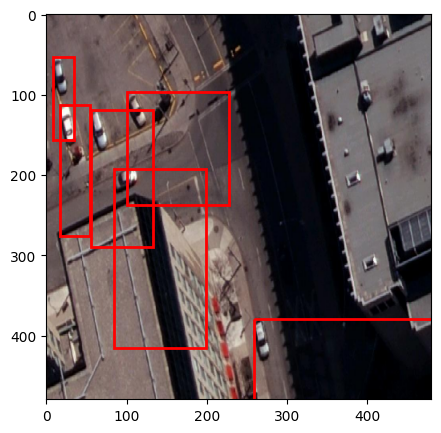

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_img_bbox(img, target):
    # Convert PIL Image to NumPy array
    img_array = np.array(img)

    # Permute dimensions if it's a PyTorch tensor
    if isinstance(img_array, torch.Tensor):
        img_array = img_array.permute(1, 2, 0)

    # Plot the image and bounding boxes
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img_array)
    for box in target['boxes']:
        x, y, w, h = box
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        a.add_patch(rect)
    plt.show()

print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img)
#     print(target['boxes'])
    for box in target['boxes']:
        x, y, w, h = box.cpu().numpy()  # Move the tensor to CPU and convert to NumPy array
        #print("-------x------------")
        #print(x)
        #print("-------y------------")
        #print(y)
        #print("-------w------------")
        #print(w)
        #print("-------h------------")
        #print(h)
        width, height  = w-x, h-y
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        a.add_patch(rect)
    plt.show()

MODEL OUTPUT


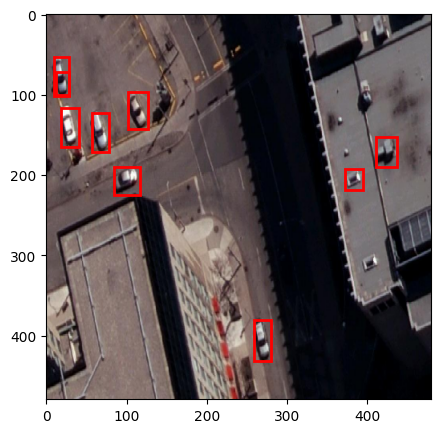

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

NMS APPLIED MODEL OUTPUT


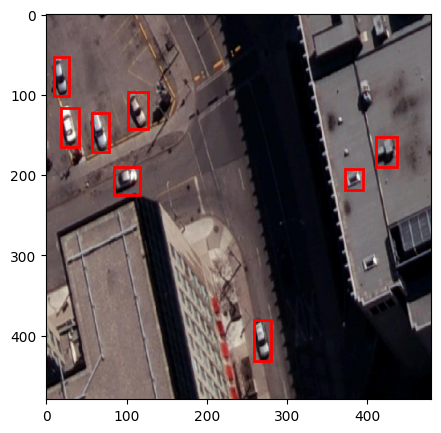

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)